# The Two-Step Boston Bed Price ZIP-Code Model

In [548]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
# import

In [549]:
#import data
bol = pd.read_csv('boston_listings.csv')
bor = pd.read_csv('boston_reviews.csv')
boc = pd.read_csv('boston_calendar.csv')

# 1) Business Requirements

1) Is the ZIP-code model following the basic rule in Real Estate “Location, Location, Location”?
2) Is the price or the price per bed more useful?
3) Do we have to optimize the database for the modelling to consider representative data by knowing what we want to predict?
4) Is a two-step model for small and large accommodations more accurate?

In [550]:
boc.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [551]:
bor.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [552]:
bol.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,calculated_host_listings_count,reviews_per_month
count,3.585000e+03,3.585000e+03,3.585000e+03,3585.000000,3585.000000,0.0,3585.000000,3585.000000,3585.000000,3571.000000,...,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,0.0,0.0,3585.000000,2829.000000
mean,8.440875e+06,2.016091e+13,2.492311e+07,58.902371,58.902371,NaN,42.340032,-71.084818,3.041283,1.221647,...,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,NaN,NaN,12.733891,1.970908
std,4.500787e+06,8.516813e-01,2.292781e+07,171.119663,171.119663,NaN,0.024403,0.031565,1.778929,0.501487,...,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116,NaN,NaN,29.415076,2.120561
min,3.353000e+03,2.016091e+13,4.240000e+03,0.000000,0.000000,NaN,42.235942,-71.171789,1.000000,0.000000,...,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,NaN,NaN,1.000000,0.010000
25%,4.679319e+06,2.016091e+13,6.103425e+06,1.000000,1.000000,NaN,42.329995,-71.105083,2.000000,1.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,NaN,1.000000,0.480000
50%,8.577620e+06,2.016091e+13,1.928100e+07,2.000000,2.000000,NaN,42.345201,-71.078429,2.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,NaN,2.000000,1.170000
75%,1.278953e+07,2.016091e+13,3.622147e+07,7.000000,7.000000,NaN,42.354685,-71.062155,4.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,6.000000,2.720000
max,1.493346e+07,2.016091e+13,9.385411e+07,749.000000,749.000000,NaN,42.389982,-71.000100,16.000000,6.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,136.000000,19.150000


# 2) Data Analysis - Data Understanding

Only Boston_listing has usefull price information, the other files are showing  just listing and booking dates. 
The size of the accomodation does have to many NaNs, the price data have to be converted.

In [553]:
#Convert string of prices to Floats
string_to_number = lambda col: col.replace('$','').replace(',','')

bol['price']=bol['price'].apply(string_to_number).astype(float)

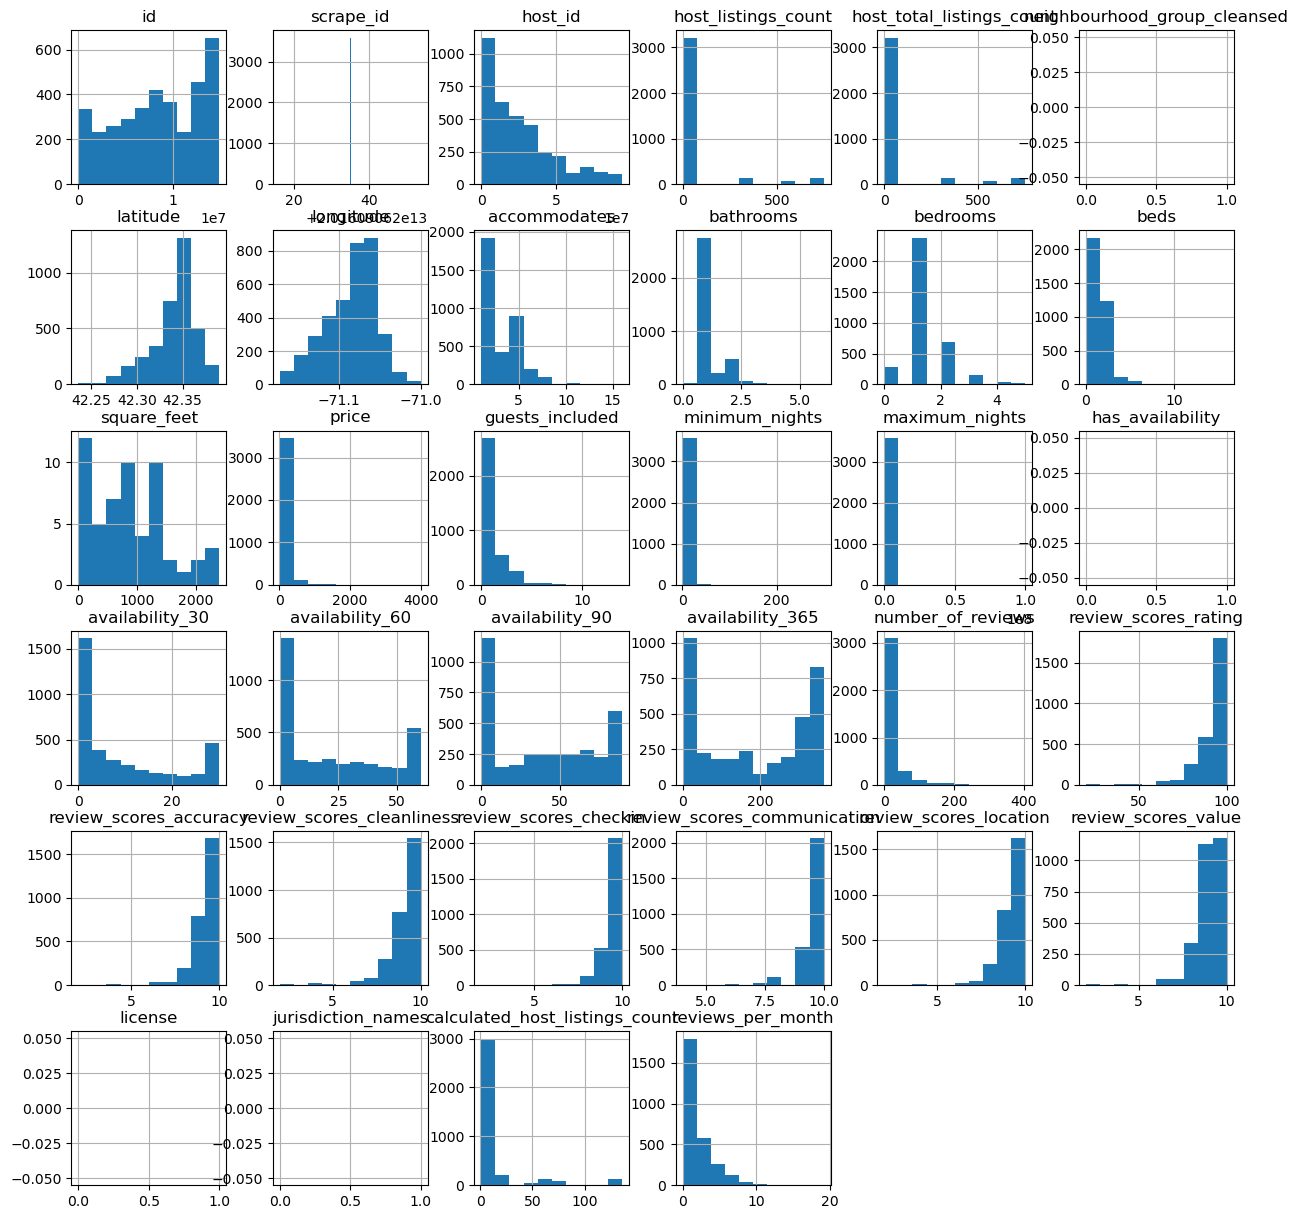

In [554]:
bol.hist(figsize=(15,15));

## 2a) First Data Cleaning

Checking the parameter to form a representative data base 
for a Price Model based on the Location to predict a price for average customers. 

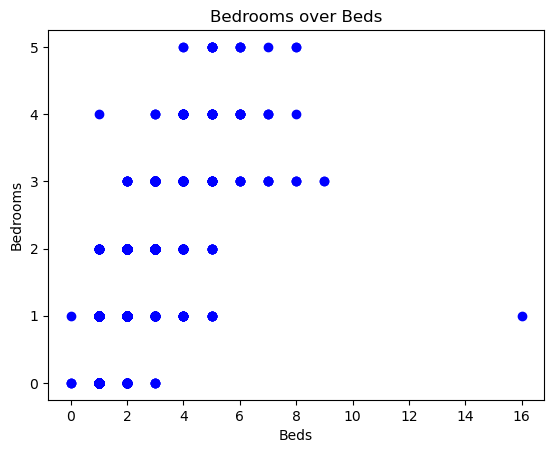

In [555]:
# Show the size of the appartmens and a relationship between beds and bedrooms
plt.plot(bol['beds'], bol['bedrooms'],'bo')
plt.xlabel('Beds')
plt.ylabel('Bedrooms')
plt.title('Bedrooms over Beds')
plt.show()

In [556]:
# Checking the total number of accomodation in a specific zipcode
bol['zipcode'].value_counts()

zipcode
02116          388
02130          331
02118          247
02215          236
02134          232
02114          231
02127          180
02135          172
02115          169
02128          146
02125          129
02120          115
02113          101
02119          100
02111           99
02129           90
02124           80
02210           75
02108           72
02131           65
02109           51
02122           44
02132           37
02136           29
02121           29
02126           24
02110           13
02145           12
02446            8
02143            7
02138            6
02139            6
02445            5
02467            5
02163            3
02141            3
02218            1
02472            1
02186            1
02169            1
02108 02111      1
02134-1704       1
02142            1
Name: count, dtype: int64

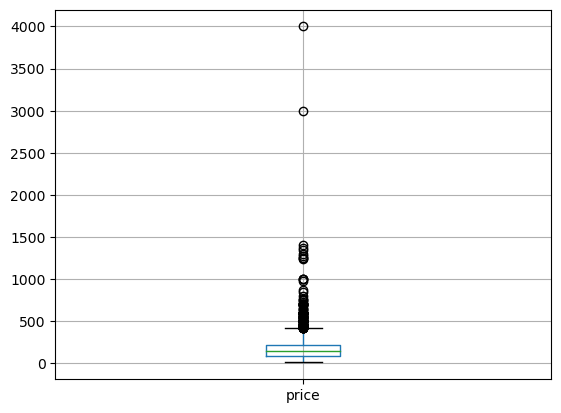

In [557]:
# Showing the Total Price distribution an boxplot
bol.boxplot(column = ['price']);

### Data Cleaning: Define a clear and statistically stable database


        
1) The 16 Beds in one Bedroom, 9 Beds in 3 Bedroom and Accomodation without Beds are not used for modelling.

2) Zipcodes < 5 are also not used.

3) Accomodation over 900$ are not fitting to the normal booking customer and far out of the average level (see Boxplot) and
such a prive level is not predicted numerically.

4) Missing important Values are dropped. In the caes of modelling dropping is better than estimation, 
especially if the number ist low.


In [558]:
# Use only datasets with < 10 Beds
bol_bed = bol[bol['beds'] < 10]

In [559]:
# Use only datasets with beds > 0 (to avoid  divide by zero)
bol_bed = bol_bed[bol_bed['beds'] > 0]

In [560]:
# Not using zip with data set <5
bol_zip = bol_bed[bol_bed['zipcode'] != '02108 02111']
bol_zip = bol_zip[bol_zip['zipcode'] != '02186']
bol_zip = bol_zip[bol_zip['zipcode'] != '02169']
bol_zip = bol_zip[bol_zip['zipcode'] != '02218']
bol_zip = bol_zip[bol_zip['zipcode'] != '02472']
bol_zip = bol_zip[bol_zip['zipcode'] != '02142']
bol_zip = bol_zip[bol_zip['zipcode'] != '02134-1704']
bol_zip = bol_zip[bol_zip['zipcode'] != '02141']
bol_zip = bol_zip[bol_zip['zipcode'] != '02163']


In [561]:
# Max Price 900
bol_billig = bol_zip[bol_zip['price'] < 900]
bol_cleaned = bol_billig

In [562]:
# checking zip data
bol_cleaned['zipcode'].value_counts()

zipcode
02116    384
02130    331
02118    245
02215    234
02134    230
02114    229
02127    179
02135    171
02115    166
02128    146
02125    126
02120    115
02113    101
02111     99
02119     99
02129     89
02124     79
02210     73
02108     71
02131     65
02109     51
02122     44
02132     37
02121     29
02136     29
02126     24
02110     13
02145     12
02446      8
02143      7
02138      6
02139      6
02445      5
02467      5
Name: count, dtype: int64

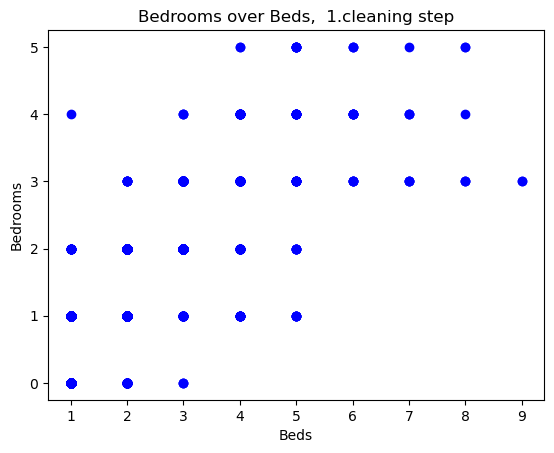

In [563]:
# checking bed and bedroom data (16 bed in one room not used anymore)
plt.plot(bol_cleaned['beds'], bol_cleaned['bedrooms'],'bo')
plt.xlabel('Beds')
plt.ylabel('Bedrooms')
plt.title('Bedrooms over Beds,  1.cleaning step')
plt.show()

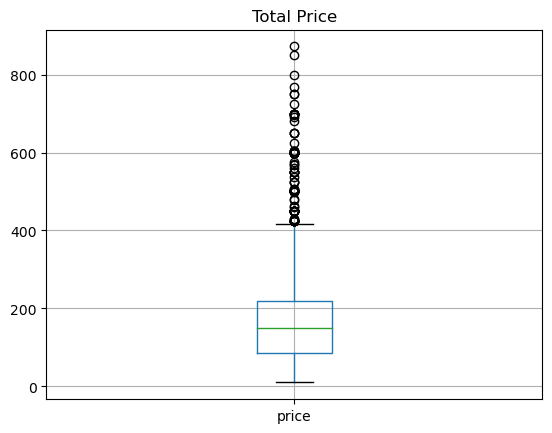

In [564]:
# checking price data as boxplot
plt.title('Total Price')
bol_cleaned.boxplot(column = ['price']);

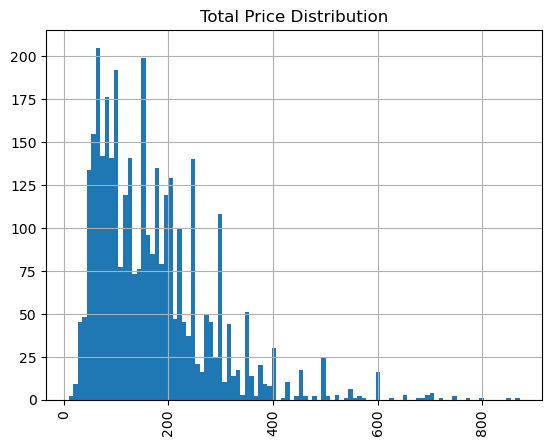

In [565]:
# and checking price data distribution over price
plt.title('Total Price Distribution')
bol_cleaned['price'].hist(bins=100, xrot=90);

In [566]:
bol_droped = bol_cleaned.dropna(subset=['zipcode', 'property_type', 'bathrooms', 'bedrooms','room_type','beds','price'])

## New Parameter: Price per Bed and Beds per Bedrooms

For checking the quality of the Dataset Beds per Bedrooms is used in addation for comparing small and lage accomodations the price per bed is calculated also

In [567]:
bol_final = bol_droped.assign(price_bed= bol_droped['price']/bol_cleaned['beds'])

In [568]:
bol_final = bol_final.assign(beds_bedroom= bol_final['beds']/bol_final['bedrooms'])

In [569]:
bo = bol_final

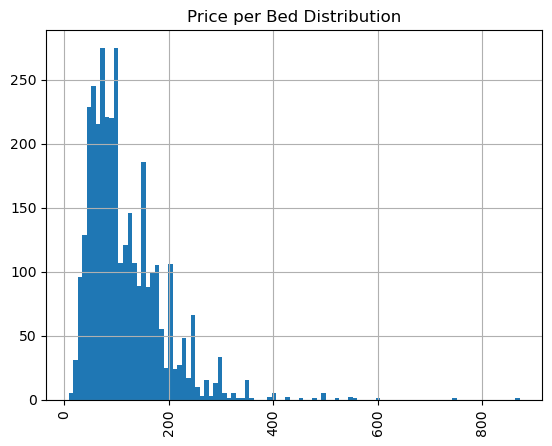

In [570]:
# and checking new Price per Bed price distribution
plt.title('Price per Bed Distribution')
bo['price_bed'].hist(bins=100, xrot=90);

In [571]:
# Checking the Database: Do we lost too many datasets

In [572]:
# Size of starting dataset
bol.shape[0]

3585

In [573]:
# Size of current dataset
bo.shape[0]

3486

### First Cleaning an Preparation of the Dataset is finished

## 2b) Second Cleaning to Show and Prepare responible Modelling Database

In [574]:
# Defining frequently used plots 
def priceplot (dataframe,title):
    '''
    This Function provides a Box Plot of the Price Types 
        Price     Total price of the accomodation
        Price_Bed Price per Bed of the accomodation

    Input
        Dataframe show
        Title of the Diagramm
    
    Output
        Boxplot 
    '''
    plt.title(title)
    plt.xlabel('Price Type Distribution')
    plt.ylabel('Dollar')
    dataframe.boxplot(column=['price', 'price_bed'])

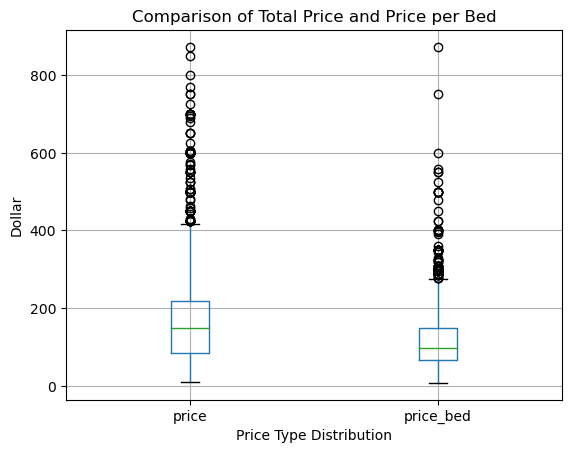

In [575]:
priceplot(bo,'Comparison of Total Price and Price per Bed')

The max value price and price per beds is equal (some expensive single bed rooms), but the median decrased clearly.

In [576]:
# Checking the Number of propety types to identify low numbers
roomType_DF=bo.groupby('property_type').id.count()
roomType_DF=roomType_DF.reset_index()
roomType_DF=roomType_DF.rename(columns={'id':'number_Of_Listings'})
roomType_DF

,property_type,number_Of_Listings
0,Apartment,2541
1,Bed & Breakfast,37
2,Boat,12
3,Condominium,228
4,Dorm,2
5,Entire Floor,4
6,Guesthouse,1
7,House,547
8,Loft,38
9,Other,17


In [577]:
# Defining  frequently used heatmaps 
def pricemaps (dataframe):
    '''
    This Function provides two Heatmap of the Total Price and the Price per Bed of an accomodation
 
    Input
        Dataframe show
    
    Output
        Heatmap 1 of mean Total Price over Room- and Apparment types
        Heatmap 2 of mean Price per Bed over Room- and Apparment types

    '''
 
    # showing the total price per bed  over zipcode and number of Beds
    plt.figure(figsize=(8,3));
    plt.title('Distribution of the Total Price over Room- and Appartment-Types')
    sns.heatmap(bo.groupby(['property_type', 'room_type']).price.mean().unstack(),annot=True, fmt=".2f");
    # showing the price per bed  over zipcode and number of Beds
    plt.figure(figsize=(8,3));
    plt.title('Distribution of the Price per Bed over Room- and Appartment-Types')
    sns.heatmap(bo.groupby(['property_type', 'room_type']).price_bed.mean().unstack(),annot=True, fmt=".2f");

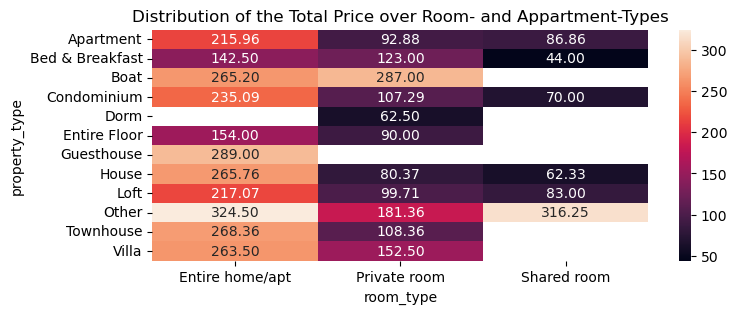

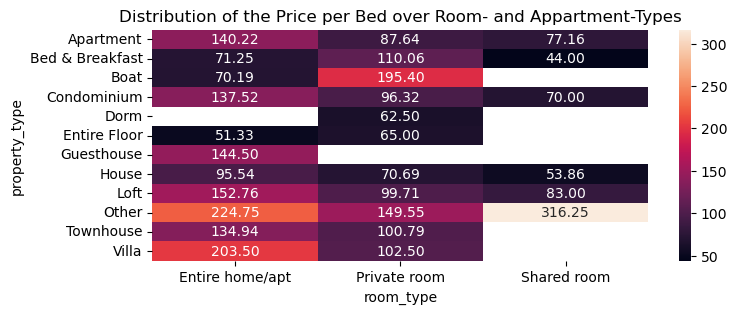

In [578]:
pricemaps(bo)

In [579]:
# Reducing the groups of property type 
#   villa (6), guesthouse (1), townhouse (53) move to house (547+60), prices are compareable
#    entier floor (4) und dorm (2) move to Apartment (2541+6), prices are compareable
bo.property_type.replace({
    'Guesthouse' : 'House',
    'Villa' : 'House',
    'Townhouse' : 'House',
    'Entire Floor' : 'Apartment',  
    'Dorm' : 'Apartment',  
       }, inplace=True)

In [580]:
# Property tye "Other" is small, not described well and has a very high average price at shared room. Not fitting weel
# Is not used for modelling anymore
bo = bo[bo['property_type'] != 'Other']

In [581]:
# check final property type distribution
roomType_DF=bo.groupby('property_type').id.count()
roomType_DF=roomType_DF.reset_index()
roomType_DF=roomType_DF.rename(columns={'id':'number_Of_Listings'})
roomType_DF

,property_type,number_Of_Listings
0,Apartment,2547
1,Bed & Breakfast,37
2,Boat,12
3,Condominium,228
4,House,607
5,Loft,38


The Number of boats is small, but boat ist kept in the database

### Compare starting and final price an room_type distribution

In [582]:
roomType_DF=bol.groupby('room_type').id.count()
roomType_DF=roomType_DF.reset_index()
roomType_DF=roomType_DF.rename(columns={'id':'number_Of_Listings'})
roomType_DF

,room_type,number_Of_Listings
0,Entire home/apt,2127
1,Private room,1378
2,Shared room,80


In [583]:
roomType_DF=bo.groupby('room_type').id.count()
roomType_DF=roomType_DF.reset_index()
roomType_DF=roomType_DF.rename(columns={'id':'number_Of_Listings'})
roomType_DF

,room_type,number_Of_Listings
0,Entire home/apt,2073
1,Private room,1323
2,Shared room,73


In [584]:
roomType_DF=bol.groupby('room_type').price.mean()
roomType_DF=roomType_DF.reset_index()
roomType_DF

,room_type,price
0,Entire home/apt,227.436765
1,Private room,96.041364
2,Shared room,92.762500


In [585]:
roomType_DF=bo.groupby('room_type').price.mean()
roomType_DF=roomType_DF.reset_index()
roomType_DF

,room_type,price
0,Entire home/apt,221.353594
1,Private room,91.684051
2,Shared room,82.684932


In [586]:
# compare average price and average prive per bed
roomType_DF=bo.groupby('room_type').price_bed.mean()
roomType_DF=roomType_DF.reset_index()
roomType_DF=roomType_DF.rename(columns={'id':'Price Bed mean'})
roomType_DF

,room_type,price_bed
0,Entire home/apt,136.636903
1,Private room,84.263341
2,Shared room,73.795662


### Checking the Database: 

1) Do we lost too many datasets: Again, no we did not.
2) Prices compareable, but slightly lower due to deleting very expensive accomodations.

## Showing Price - Bed Distribution

In [587]:
# Calculate the average price over the number of bedrooms
price_room = bo.groupby('bedrooms').price.mean()

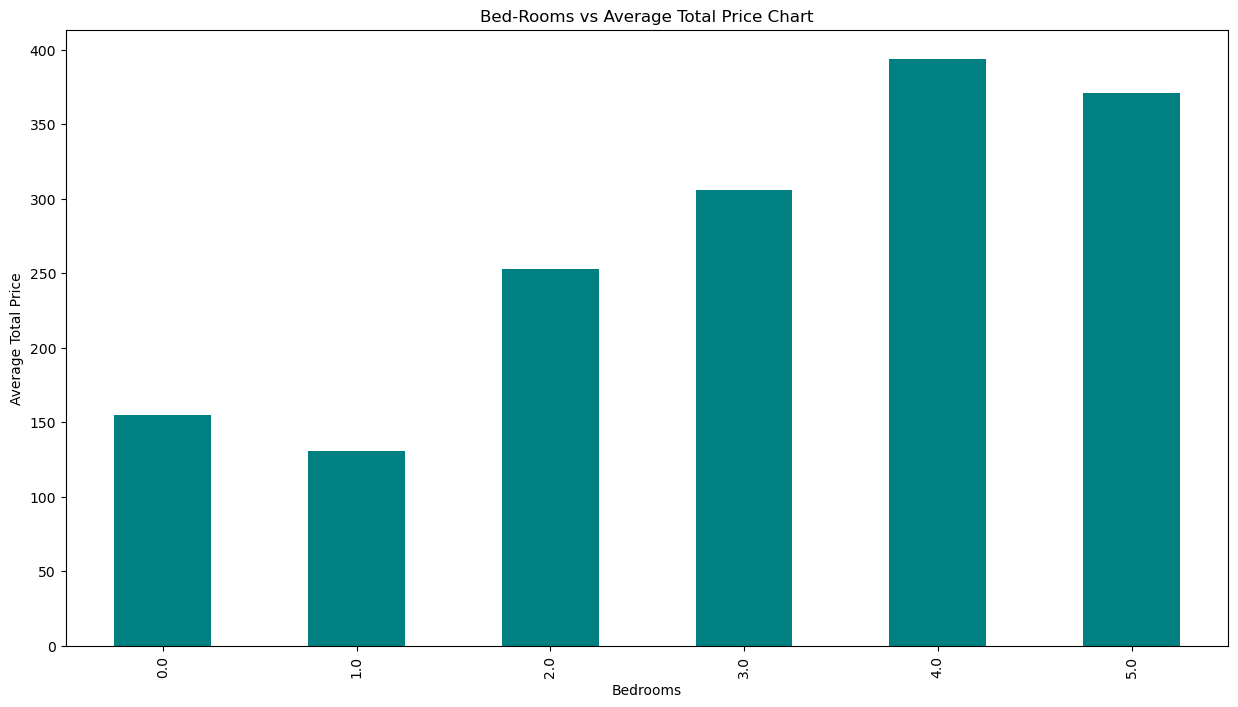

In [588]:
plt.figure(figsize=(15,8));
price_room.plot(kind='bar', color='teal');
plt.xlabel('Bedrooms')
plt.ylabel('Average Total Price')
plt.title('Bed-Rooms vs Average Total Price Chart');

In [589]:
price_bed = bo.groupby('beds').price.mean()

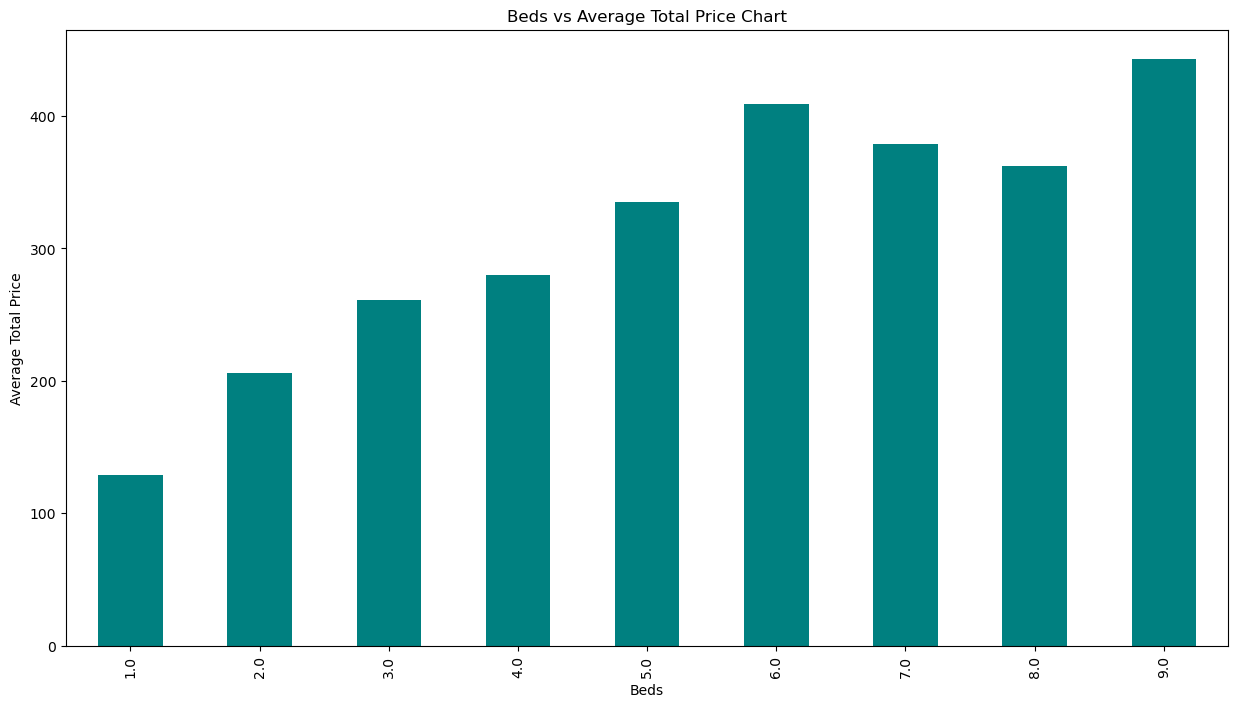

In [590]:
plt.figure(figsize=(15,8));
price_bed.plot(kind='bar', color='teal');
plt.xlabel('Beds')
plt.ylabel('Average Total Price')
plt.title('Beds vs Average Total Price Chart');

In [591]:
price_bed_bed = bo.groupby('beds').price_bed.mean()

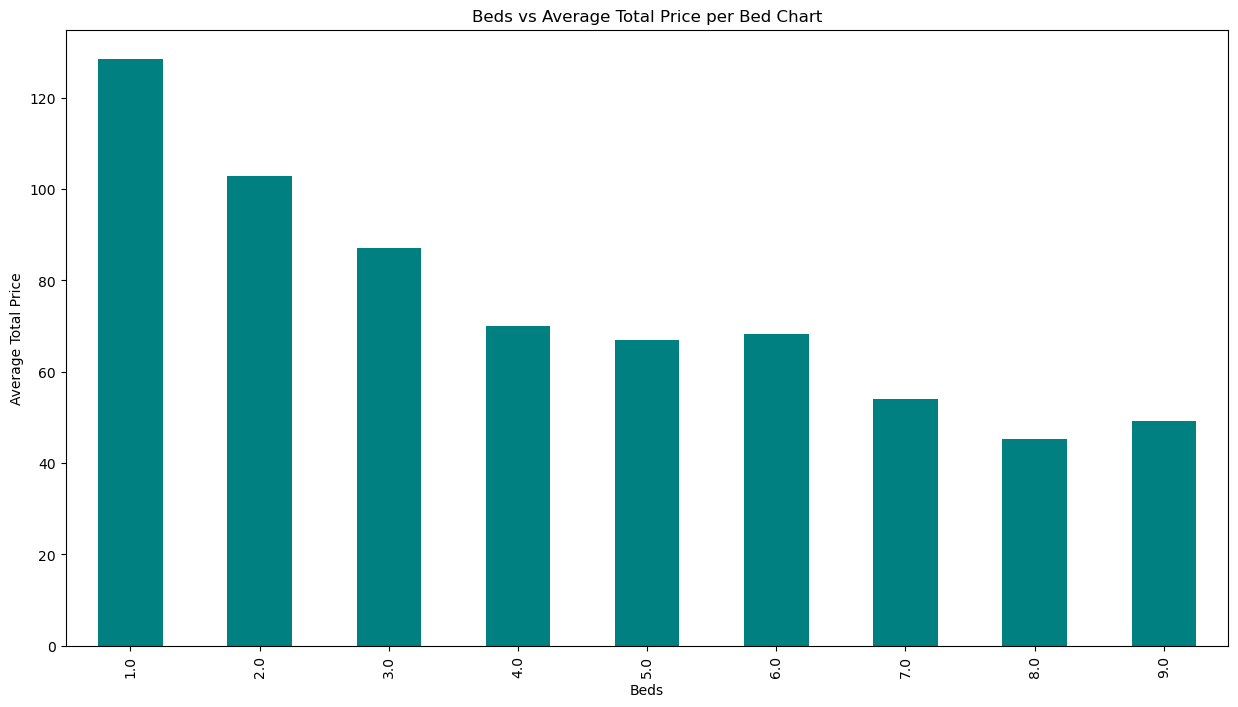

In [592]:
plt.figure(figsize=(15,8));
price_bed_bed.plot(kind='bar', color='teal');
plt.xlabel('Beds')
plt.ylabel('Average Total Price')
plt.title('Beds vs Average Total Price per Bed Chart');

### Summary Beds and  Price per Beds

1) Studios without a Bedroom are more expensive
2) The prices increase more or less linear up to 3 Beds and 3 Bedrooms
3) Very large appartmens getting cheaper
4) he price per bed decreases up to 4 beds, the the price gest stable. 4 Beds ist the optimum for the customer

## Room- / Property type and City

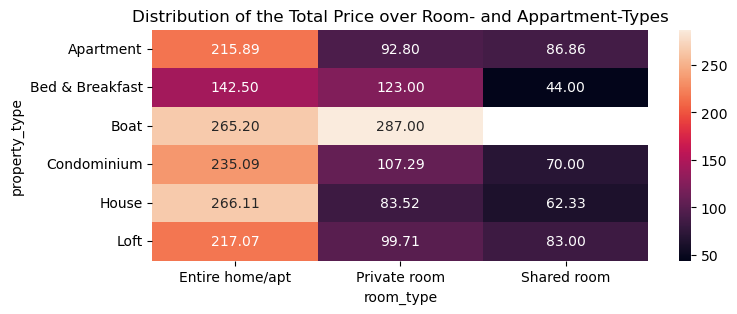

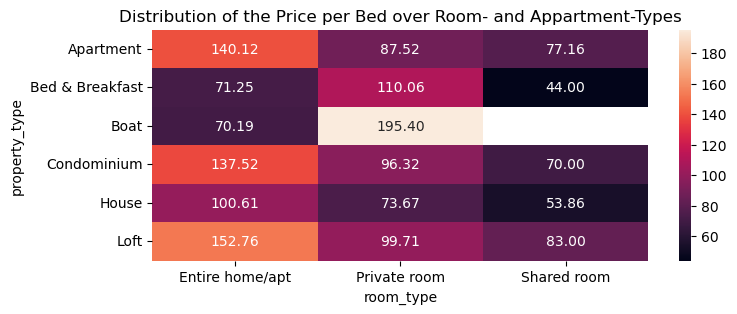

In [593]:
pricemaps(bo)

As pointed out earlier: Boats are a small number and the most expensive private room far out of the average!!

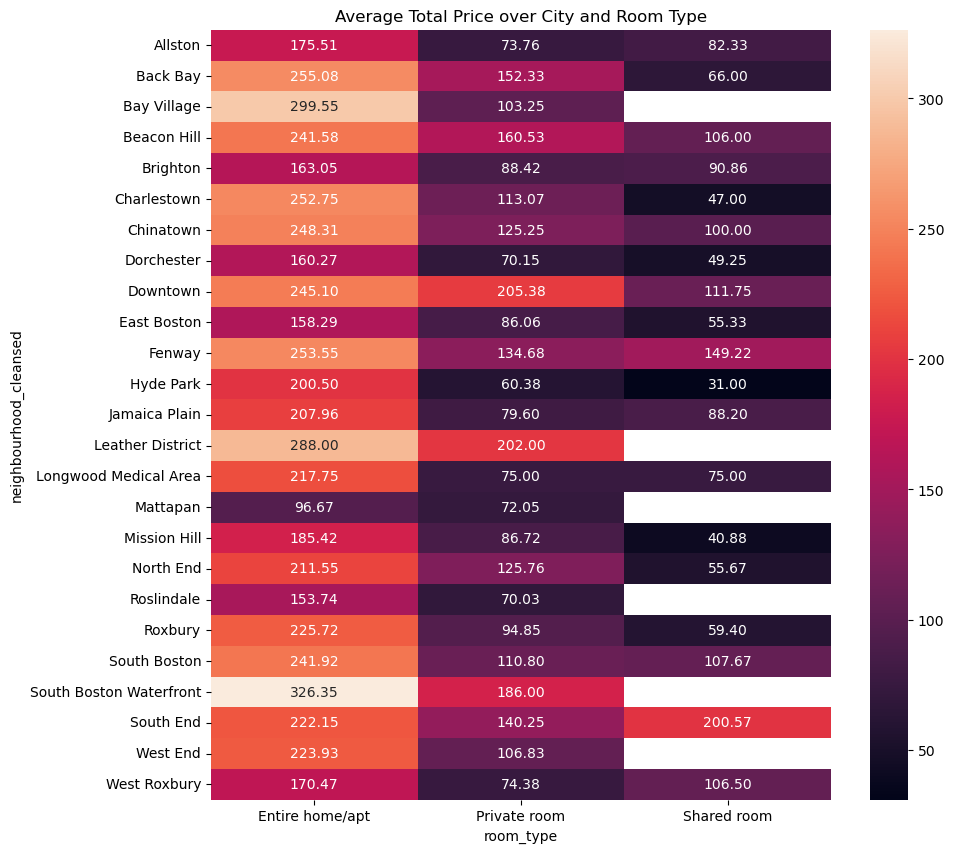

In [594]:
#Compare Room type and city
plt.figure(figsize=(10,10));
plt.title('Average Total Price over City and Room Type')
sns.heatmap(bol.groupby(['neighbourhood_cleansed', 'room_type']).price.mean().unstack(),annot=True, fmt=".2f");

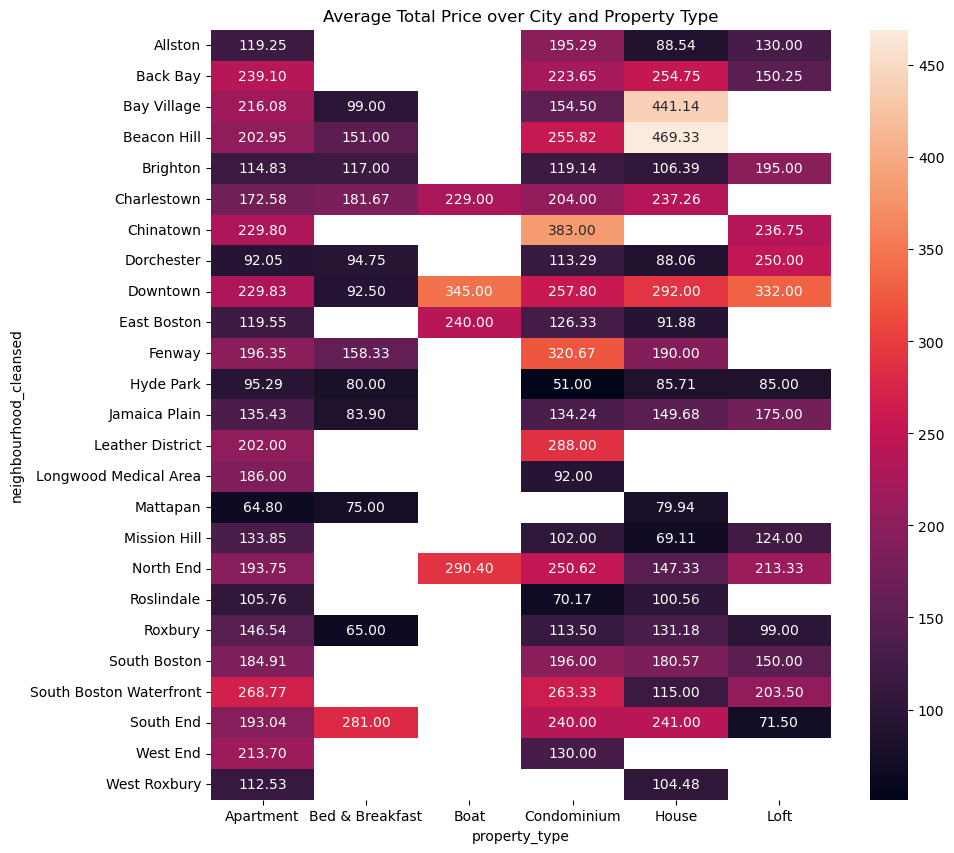

In [595]:
# Compare property type and city
plt.figure(figsize=(10,10));
plt.ylabel('City')
plt.title('Average Total Price over City and Property Type')
sns.heatmap(bo.groupby(['neighbourhood_cleansed', 'property_type']).price.mean().unstack(),annot=True, fmt=".2f");

However, this heatmap is interesting for detailed analysis, but not really clear

In [596]:
price_per_city = bol.groupby('neighbourhood_cleansed',sort=True).price.mean()
price_per_city_sort = price_per_city.sort_values()

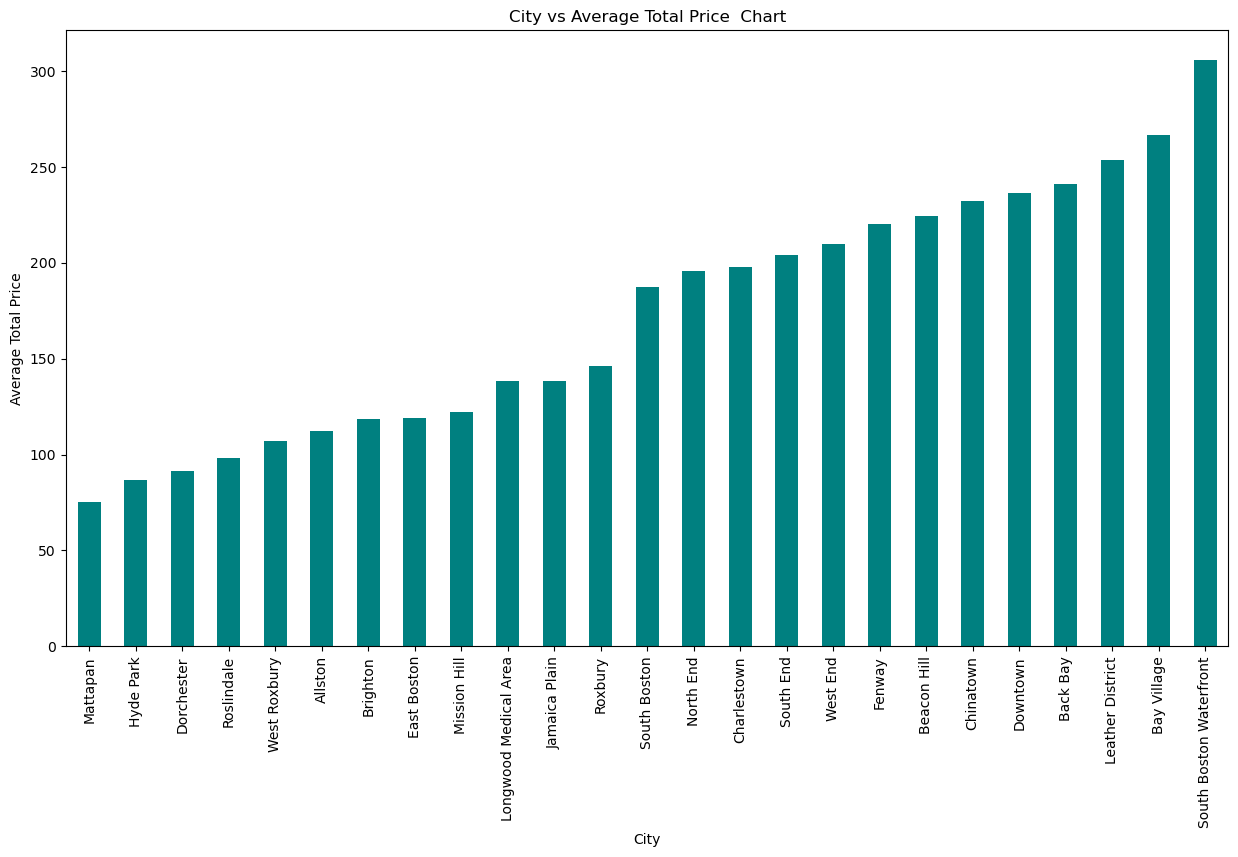

In [597]:
plt.figure(figsize=(15,8));
price_per_city_sort.plot(kind='bar', color='teal');
plt.xlabel('City')
plt.ylabel('Average Total Price')
plt.title('City vs Average Total Price  Chart');

## Lets use the ZIP Code in addtion to compare

In [598]:
# compare the appatment price and the price per bed over city and zip code
price_zip_city = bo.groupby(['neighbourhood_cleansed','zipcode']).price.mean()
price_zip_city_bed = bo.groupby(['neighbourhood_cleansed','zipcode']).price_bed.mean()

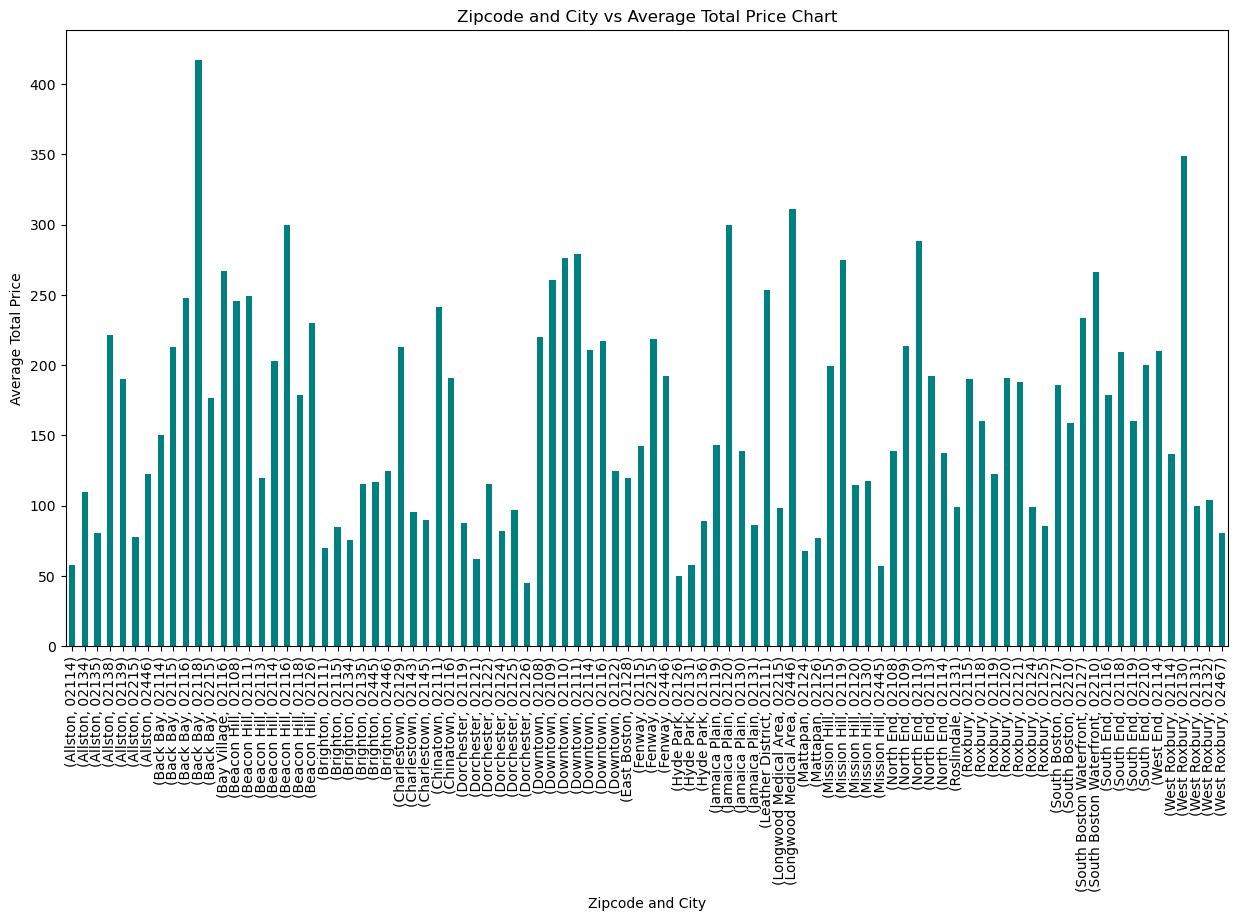

In [599]:
plt.figure(figsize=(15,8));
price_zip_city.plot(kind='bar', color='teal');
plt.xlabel('Zipcode and City' )
plt.ylabel('Average Total Price')
plt.title('Zipcode and City vs Average Total Price Chart');

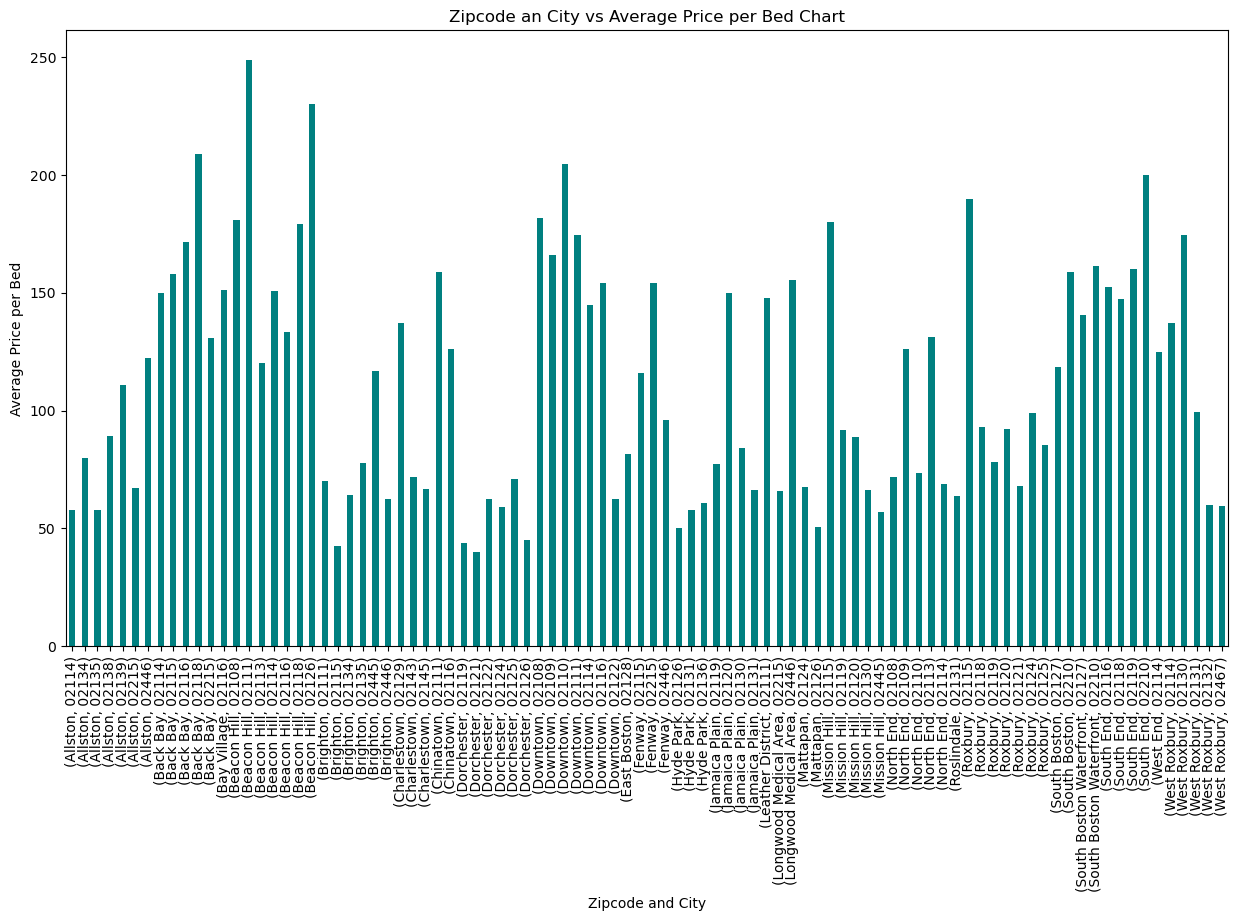

In [600]:
plt.figure(figsize=(15,8));
price_zip_city_bed.plot(kind='bar', color='teal');
plt.xlabel('Zipcode and City')
plt.ylabel('Average Price per Bed')
plt.title('Zipcode an City vs Average Price per Bed Chart');

### The average Price within a city having different zip codes are very unequal.

The Zipcode is usually a smaler area based on postmen distribution and not on historical city names.

## Let change to Zipcode and Price per Bed instead of Total Price

In [601]:
# calulate price per zipcode and sort it
price_per_zip = bo.groupby('zipcode',sort=True).price.mean()
price_per_zip_sort = price_per_zip.sort_values()
price_per_zip_sort

zipcode
02467     80.400000
02126     80.958333
02124     81.506329
02136     88.793103
02145     89.833333
02445     92.800000
02143     95.571429
02125     96.373016
02131     96.907692
02121    101.310345
02132    103.783784
02134    108.419214
02135    114.611765
02122    115.906977
02128    119.684932
02120    126.173913
02119    126.848485
02130    138.909091
02446    178.500000
02115    181.024845
02127    187.789474
02139    190.166667
02113    191.710000
02114    203.834061
02118    205.974468
02215    208.802575
02129    213.101124
02138    221.500000
02116    225.860526
02109    230.574468
02108    233.028571
02111    253.535354
02210    263.808219
02110    281.083333
Name: price, dtype: float64

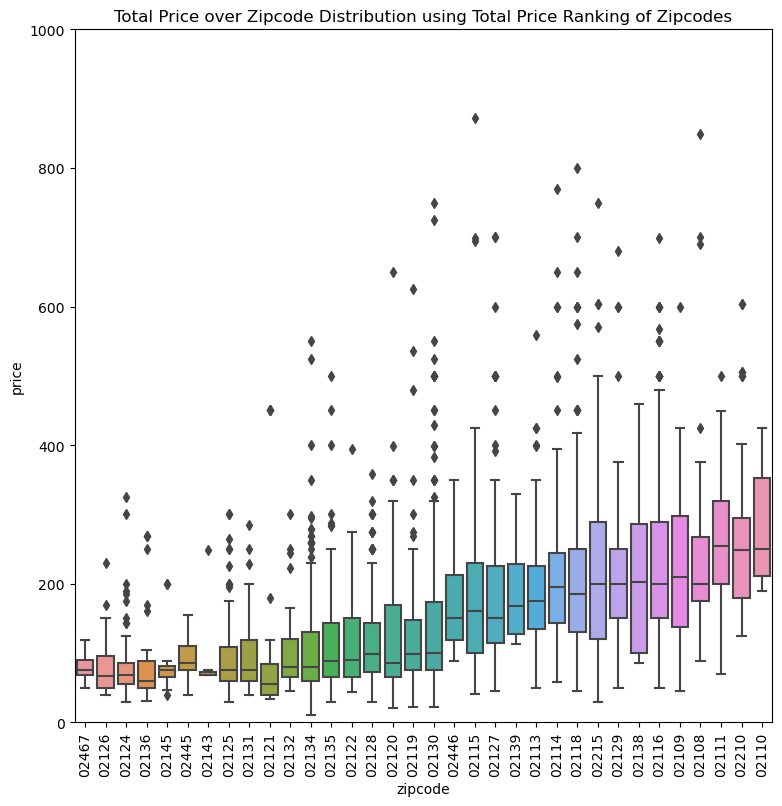

In [602]:
plt.figure(figsize = (9,9))
plt.xticks(rotation=90)
plt.ylim(0, 1000)
plt.title('Total Price over Zipcode Distribution using Total Price Ranking of Zipcodes')
sns.boxplot(y=bo["price"], x=bo["zipcode"], 
        order = ["02467", "02126", "02124", "02136", "02145", "02445", "02143", "02125", "02131", "02121", "02132", "02134", 
                 "02135", "02122", "02128", "02120", "02119", "02130", "02446", "02115", "02127", "02139", "02113", "02114",
                 "02118", "02215", "02129", "02138", "02116", "02109", "02108", "02111", "02210","02110"]);

In [603]:
# Defining  frequently used heatmaps 
def pricezipmaps (dataframe):
    '''
    This Function provides two Heatmap of the Mean Total Price and Mean Price per Beds of the accomodation
        in one Zipcode separated over the number of Beds
 
    Input
        Dataframe show
    
    Output
        Boxplot 

    '''
# showing the total price over zipcode and number of Beds
    plt.figure(figsize=(10,10));
    plt.title('Distribution of the Total Price over Zipcode and Bedrooms ')
    sns.heatmap(bo.groupby(['zipcode', 'beds']).price.mean().unstack(),annot=True, fmt=".2f");
# showing the price per bed  over zipcode and number of Beds
    plt.figure(figsize=(10,10));
    plt.title('Distribution of the Price per Bed over Zipcode and Bedrooms ')
    sns.heatmap(bo.groupby(['zipcode', 'beds']).price_bed.mean().unstack(),annot=True, fmt=".2f");

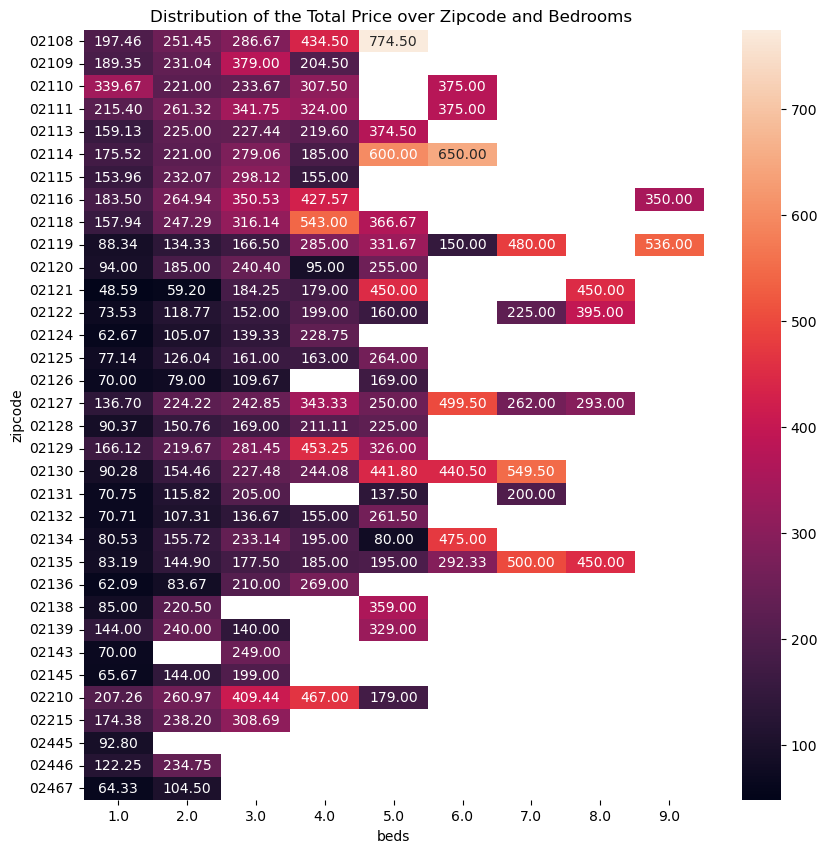

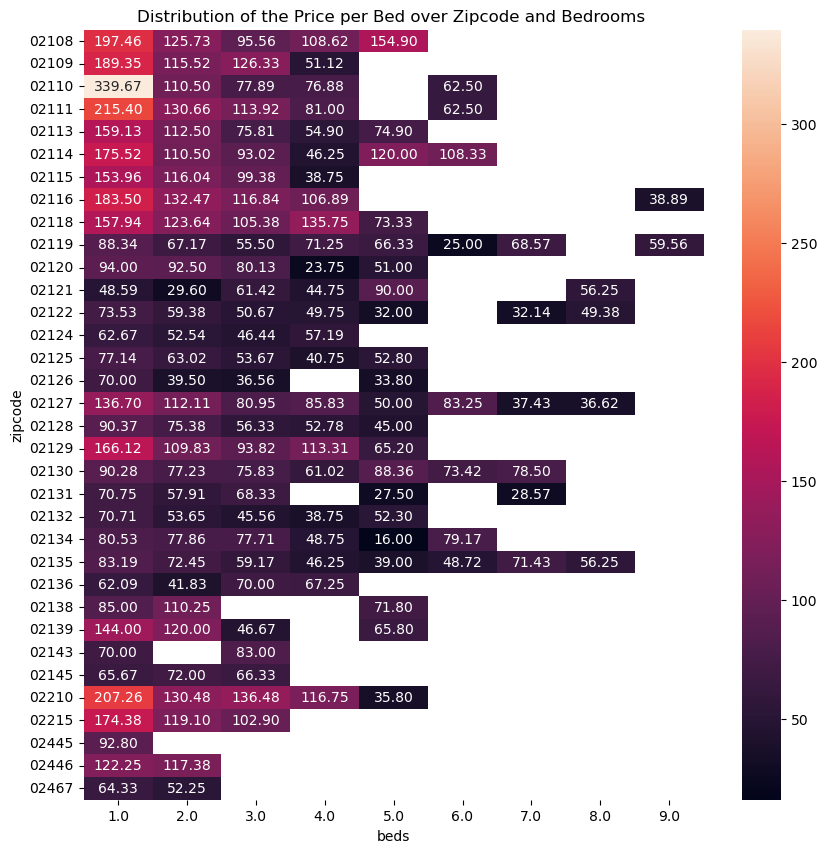

In [604]:
pricezipmaps(bo)

## The change to Price per beds is showing a better fitting to the zipcode. 
The using of price only ist more focused on the size of the apparment than of the location. A comparison of City and Zipcode is shown below.

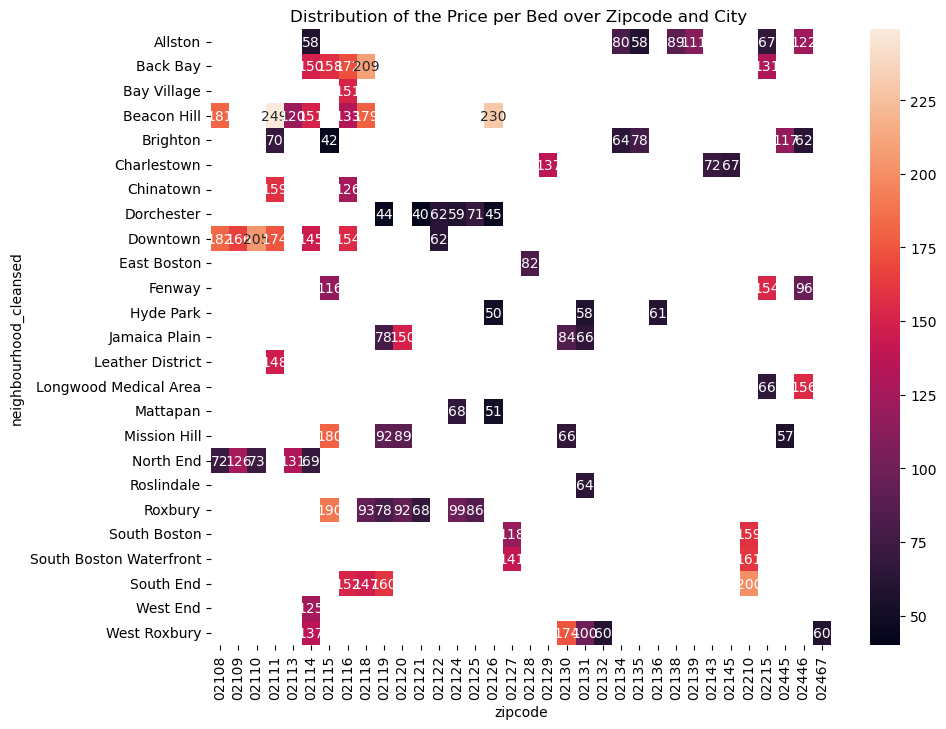

In [605]:
plt.figure(figsize=(10,8));
plt.title('Distribution of the Price per Bed over Zipcode and City ')
sns.heatmap(bo.groupby(['neighbourhood_cleansed', 'zipcode']).price_bed.mean().unstack(),annot=True, fmt=".0f");

The Price per Bed Distribution is, as already shown, not equal in the corresponding city. 

# Zipcode + Price per Bed fits the "Location - Location - Location" wisdom.

Distributions are shown below.

In [606]:
# calulate price per bed and zipcode and sort it
price_bed_zip = bo.groupby('zipcode',sort=True).price_bed.mean()
price_bed_zip_sort = price_bed_zip.sort_values()
price_bed_zip_sort

zipcode
02121     48.643678
02126     57.956944
02467     59.500000
02132     59.953153
02124     59.982068
02136     60.896552
02122     62.486849
02131     65.226740
02145     66.777778
02125     71.497090
02143     71.857143
02135     77.285364
02119     78.882596
02134     79.283115
02128     81.665525
02130     83.928687
02138     89.016667
02120     89.939855
02445     92.800000
02139    110.744444
02127    119.263541
02446    119.812500
02113    131.211333
02129    136.994944
02109    140.636525
02115    140.877329
02118    142.600355
02114    143.240902
02215    147.645207
02110    150.034722
02116    161.458260
02210    161.964155
02111    163.742424
02108    178.067381
Name: price_bed, dtype: float64

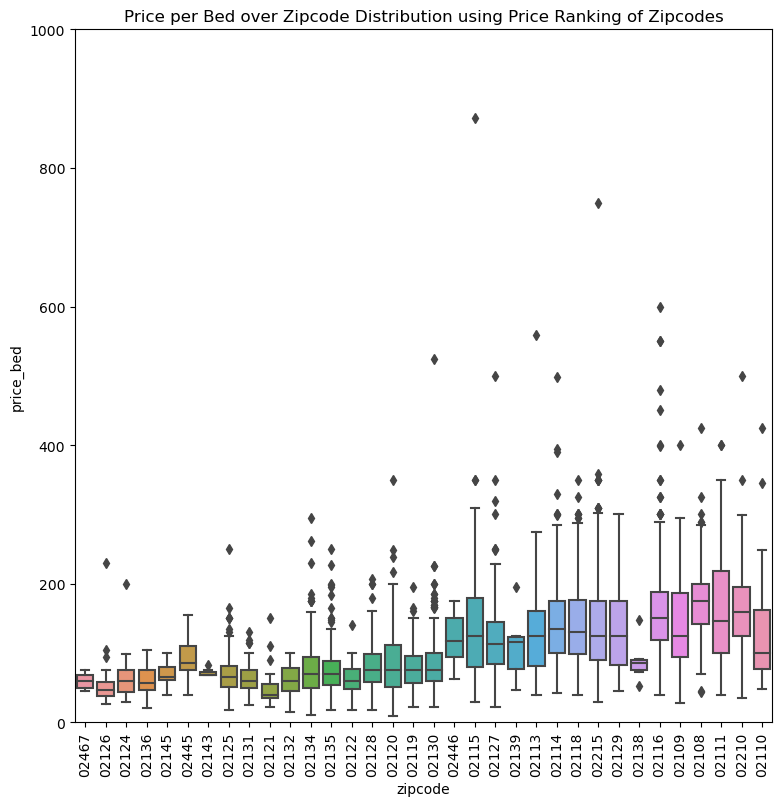

In [607]:
# showing perce per bed over former zip sorting
plt.figure(figsize = (9,9))
plt.xticks(rotation=90)
plt.ylim(0, 1000)
plt.title('Price per Bed over Zipcode Distribution using Price Ranking of Zipcodes')
sns.boxplot(y=bo["price_bed"], x=bo["zipcode"], 
        order = ["02467", "02126", "02124", "02136", "02145", "02445", "02143", "02125", "02131", "02121", "02132", "02134", 
                 "02135", "02122", "02128", "02120", "02119", "02130", "02446", "02115", "02127", "02139", "02113", "02114",
                 "02118", "02215", "02129", "02138", "02116", "02109", "02108", "02111", "02210","02110"]);

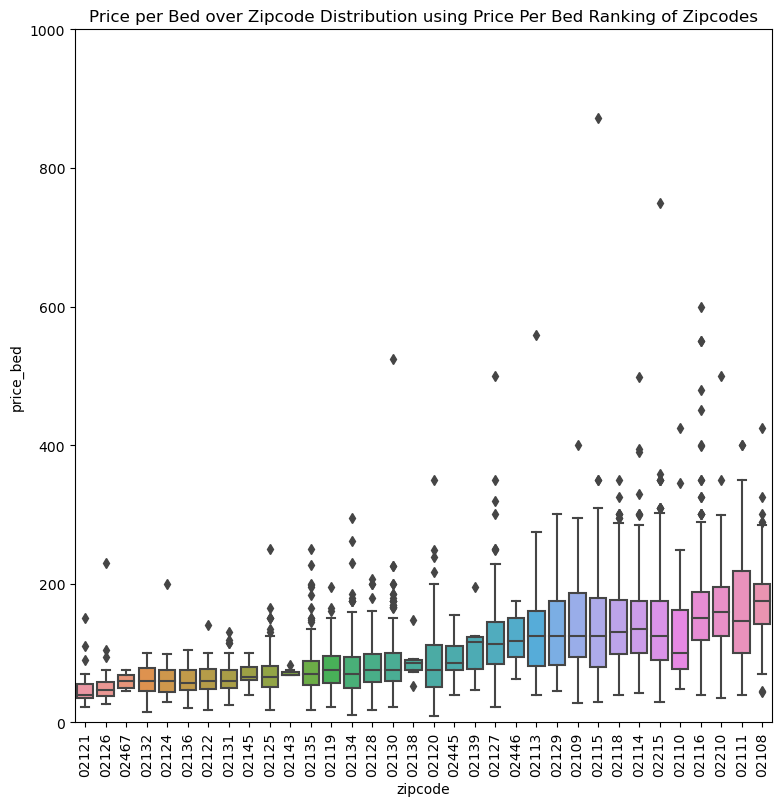

In [608]:
# showing perce per bed over former zip sorting
plt.figure(figsize = (9,9))
plt.xticks(rotation=90)
plt.ylim(0, 1000)
plt.title('Price per Bed over Zipcode Distribution using Price Per Bed Ranking of Zipcodes')
sns.boxplot(y=bo["price_bed"], x=bo["zipcode"], 
        order = ["02121", "02126", "02467", "02132", "02124", "02136", "02122", "02131", "02145", "02125", "02143", "02135", 
                 "02119", "02134", "02128", "02130", "02138", "02120", "02445", "02139", "02127", "02446", "02113", "02129",
                 "02109", "02115", "02118", "02114", "02215", "02110", "02116", "02210", "02111", "02108"]);

Conclusio : The Ranking is different and the spreading is lower. 

# 3) Model Group 1 Total Price: Comparison and Optimisation: 
    Comparing several models by reducing the data base more and more (deleting several ouliers)
    by using relevant information regarding apparments, location and so one. 
    The size ist not used (very low numbers available informaton)

## 3a) Model Step 1: Using full Database

In [609]:
# Using full Dataset for Model 1
bo1 = bo

In [610]:
Xz = bo1[['beds', 'bathrooms', 'bedrooms','zipcode']]
yz = bo1['price']
Xz_train, Xz_test, yz_train, yz_test = train_test_split(Xz, yz, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xz_train, yz_train)

LinearRegression()

In [611]:
yz_test_preds = lm_model.predict(Xz_test)
rsquared_scorez = r2_score(yz_test, yz_test_preds)
length_yz_test = len(yz_test)
"The r-squared score for your Basic / Step 1 Total Price Zipcode Model was {} on {} values.".format(rsquared_scorez, length_yz_test)

'The r-squared score for your Basic / Step 1 Total Price Zipcode Model was 0.35166502964341917 on 1041 values.'

In [612]:
Xb = bo1[['beds', 'bathrooms', 'bedrooms','zipcode']]
yb = bo1['price_bed']
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xb_train, yb_train)

LinearRegression()

In [613]:
yb_test_preds = lm_model.predict(Xb_test)
rsquared_scoreb = r2_score(yb_test, yb_test_preds)
length_yb_test = len(yb_test)
"The r-squared score for your Basic / Step 1 Bedprice Zipcode Model was {} on {} values.".format(rsquared_scoreb, length_yb_test)

'The r-squared score for your Basic / Step 1 Bedprice Zipcode Model was 0.0481153879237336 on 1041 values.'

Checking Data Quality again

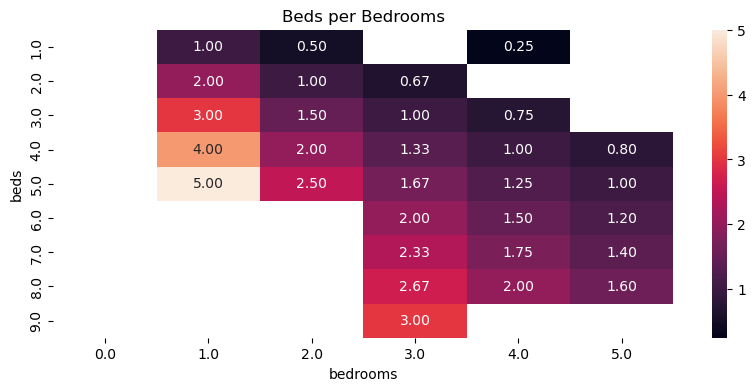

In [614]:
plt.figure(figsize=(10,4));
plt.title('Beds per Bedrooms')
sns.heatmap(bo.groupby(['beds', 'bedrooms']).beds_bedroom.mean().unstack(),annot=True, fmt=".2f");

If the number of Beds is smaller than the number of Bedrooms, the data quality for a bed model ist weak

## 3b) Model Step 2: Not using less beds then Bedrooms 
Data quality is weak, is not usable for a Bed-Price Model (Information is not so important for the Total Price Model)

In [615]:
# Delte Data sets withless beds than bedroom, not usable for a Bed-Price Model Step 1
bo2 = bo[bo['beds_bedroom'] > 0.99]

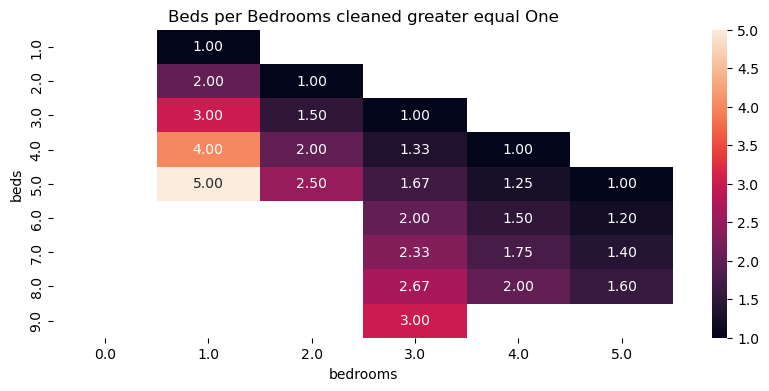

In [616]:
plt.figure(figsize=(10,4));
plt.title('Beds per Bedrooms cleaned greater equal One')
sns.heatmap(bo2.groupby(['beds', 'bedrooms']).beds_bedroom.mean().unstack(),annot=True, fmt=".2f");

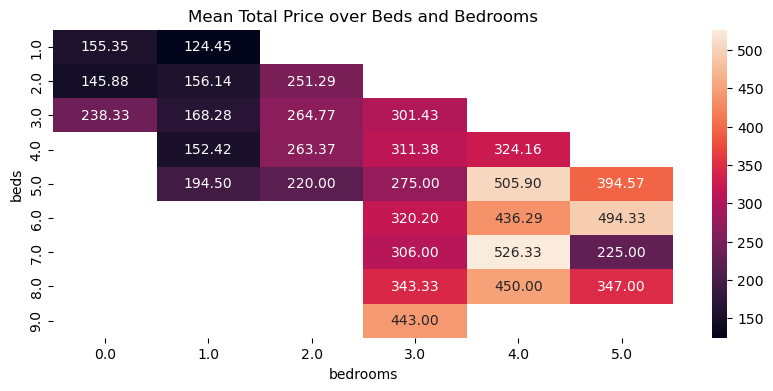

In [617]:
plt.figure(figsize=(10,4));
plt.title('Mean Total Price over Beds and Bedrooms')
sns.heatmap(bo2.groupby(['beds', 'bedrooms']).price.mean().unstack(),annot=True, fmt=".2f");

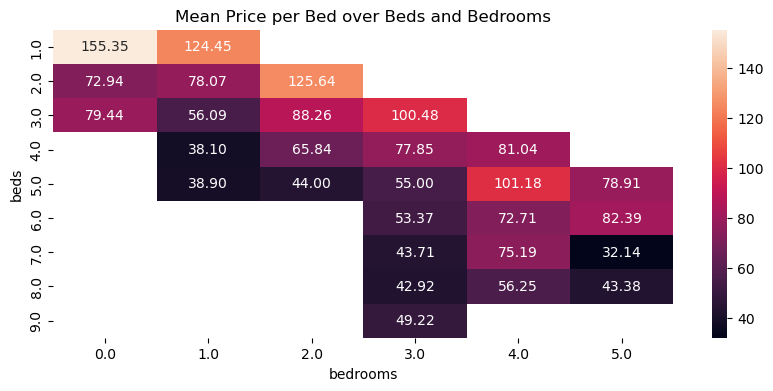

In [618]:
plt.figure(figsize=(10,4));
plt.title('Mean Price per Bed over Beds and Bedrooms')
sns.heatmap(bo2.groupby(['beds', 'bedrooms']).price_bed.mean().unstack(),annot=True, fmt=".2f");

The one bedroom appartments with more then 4 beds are also unusually, but kept in the database.

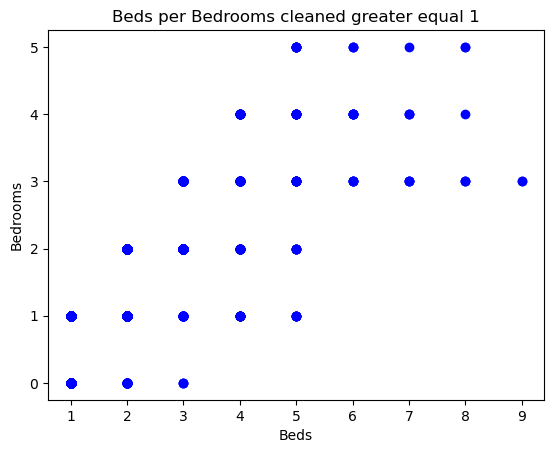

In [619]:
# Showing similar Issue using earlier shown graph
plt.plot(bo2['beds'], bo2['bedrooms'],'bo')
plt.xlabel('Beds')
plt.ylabel('Bedrooms')
plt.title('Beds per Bedrooms cleaned greater equal 1')
plt.show()

In [620]:
Xz2 = bo2[['beds', 'bathrooms', 'bedrooms','zipcode']]
yz2 = bo2['price']
Xz2_train, Xz2_test, yz2_train, yz2_test = train_test_split(Xz2, yz2, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xz2_train, yz2_train)

LinearRegression()

In [621]:
yz2_test_preds = lm_model.predict(Xz2_test)
rsquared_scorez2 = r2_score(yz2_test, yz2_test_preds)
length_yz2_test = len(yz2_test)
"The r-squared score for your St.2 Total Price Zipcode Model was {} on {} values.".format(rsquared_scorez2, length_yz2_test)

'The r-squared score for your St.2 Total Price Zipcode Model was 0.34005789837935485 on 1032 values.'

In [622]:
Xb2 = bo2[['beds', 'bathrooms', 'bedrooms','zipcode']]
yb2 = bo2['price_bed']
Xb2_train, Xb2_test, yb2_train, yb2_test = train_test_split(Xb2, yb2, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xb2_train, yb2_train)

LinearRegression()

In [623]:
yb2_test_preds = lm_model.predict(Xb2_test)
rsquared_scoreb2 = r2_score(yb2_test, yb2_test_preds)
length_yb2_test = len(yb2_test)
"The r-squared score for your St.2 Bedprice Zipcode Model was {} on {} values.".format(rsquared_scoreb2, length_yb2_test)

'The r-squared score for your St.2 Bedprice Zipcode Model was 0.06309264898704037 on 1032 values.'

## 3c) Model Step 3: Not using 9 Beds in 3 bedroooms by deleting 2 datasets

In [624]:
bo2.loc[bo2['beds']>8]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,price_bed,beds_bedroom
811,14813006,https://www.airbnb.com/rooms/14813006,20160906204935,2016-09-07,MODERN 3BR/2B apartment near Fenway!,Hey there! =) Looking for an awesome place to ...,No parties thank you. Our 2 floor home is loca...,Hey there! =) Looking for an awesome place to ...,none,No parties thank you. The neighborhood is tota...,...,NaN,NaN,t,flexible,f,f,1,1.00,59.555556,3.0
2150,11866651,https://www.airbnb.com/rooms/11866651,20160906204935,2016-09-07,3 BR|2.5 BA Renovated House Parking Top Location,Boston's Best Location! 2016 remodel of gorgeo...,Our home is a 3-story brownstone painstakingly...,Boston's Best Location! 2016 remodel of gorgeo...,none,Bay Village is the most unique neighborhood in...,...,NaN,NaN,t,strict,f,f,1,8.22,38.888889,3.0


In [625]:
bo3 = bo2[bo2['beds'] <9]
# Excluding another outlier 9 Beds in 3 Bedroom

Calculation optimized Model without 9 Beds

In [626]:
Xp3 = bo3[['beds', 'bathrooms', 'bedrooms','zipcode']]
yp3 = bo3['price']
Xp3_train, Xp3_test, yp3_train, yp3_test = train_test_split(Xp3, yp3, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xp3_train, yp3_train)

LinearRegression()

In [627]:
yp3_test_preds = lm_model.predict(Xp3_test)
rsquared_scorep3 = r2_score(yp3_test, yp3_test_preds)
length_yp3_test = len(yp3_test)
"The r-squared score for your St.3 Total Price Zipcode Model was {} on {} values.".format(rsquared_scorep3, length_yp3_test)

'The r-squared score for your St.3 Total Price Zipcode Model was 0.2703295837479278 on 1031 values.'

In [628]:
Xb3 = bo3[['beds', 'bathrooms', 'bedrooms','zipcode']]
yb3 = bo3['price_bed']
Xb3_train, Xb3_test, yb3_train, yb3_test = train_test_split(Xb3, yb3, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xb3_train, yb3_train)

LinearRegression()

In [629]:
yb3_test_preds = lm_model.predict(Xb3_test)
rsquared_scoreb3 = r2_score(yb3_test, yb3_test_preds)
length_yb3_test = len(yb3_test)
"The r-squared score for your St.3 Bedprice Zipcode Model was {} on {} values.".format(rsquared_scoreb3, length_yb3_test)

'The r-squared score for your St.3 Bedprice Zipcode Model was 0.06121176591324129 on 1031 values.'

## 3d) Model Step 4: no very expensive single Bed accommodations

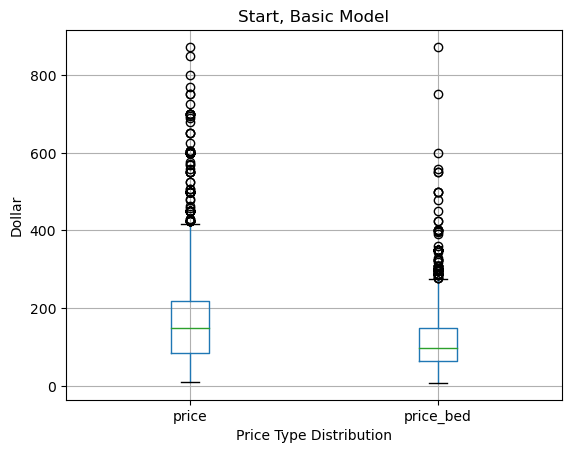

In [630]:
priceplot(bo3,'Start, Basic Model')

Is can be seen clearly, there are 6 datasets with prices per bed higher than 500 Dollar and equal total price (just one Bed). 
These datasets are deleted, since they are not representing typical customer or accommodations 
(beeing not representative for out modelling.)

In [631]:
bo2.loc[bo2['price_bed']>500]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,price_bed,beds_bedroom
408,12849985,https://www.airbnb.com/rooms/12849985,20160906204935,2016-09-07,Sublet - Mission Hill,Single Room for sublet on Hillside St on Missi...,NaN,Single Room for sublet on Hillside St on Missi...,none,NaN,...,NaN,NaN,f,flexible,f,f,1,NaN,872.0,1.0
670,13573506,https://www.airbnb.com/rooms/13573506,20160906204935,2016-09-07,North End Beauty,"My place is good for couples, solo adventurers...",NaN,"My place is good for couples, solo adventurers...",none,NaN,...,NaN,NaN,f,flexible,f,f,1,NaN,559.0,1.0
1508,13060113,https://www.airbnb.com/rooms/13060113,20160906204935,2016-09-07,Back Bay 1 Bedroom,Apartment located in the heart of Back Bay. Cl...,Originally built in 1886 as the Hotel Victoria...,Apartment located in the heart of Back Bay. Cl...,none,NaN,...,NaN,NaN,f,flexible,f,f,1,NaN,550.0,1.0
1516,2656568,https://www.airbnb.com/rooms/2656568,20160906204935,2016-09-07,1 Bedroom Apartment Copley,1 bedroom apartment in the heart of Copley squ...,NaN,1 bedroom apartment in the heart of Copley squ...,none,NaN,...,NaN,NaN,f,flexible,f,f,1,NaN,600.0,1.0
2123,3414993,https://www.airbnb.com/rooms/3414993,20160906204935,2016-09-07,Gorgeous Condo w Huge Patio Back Bay Boston Co...,One Bedroom One Bath Condo with Spacious Outdo...,Experience refined luxury living at it's best!...,One Bedroom One Bath Condo with Spacious Outdo...,none,This condo is literally steps from everything!...,...,NaN,NaN,t,strict,f,f,1,NaN,550.0,1.0
2394,12359181,https://www.airbnb.com/rooms/12359181,20160906204935,2016-09-07,shared room in the heart of Boston,3 mins walk to berkelee! 5 mins walk to Newbur...,This building belongs to berkelee and has elev...,3 mins walk to berkelee! 5 mins walk to Newbur...,none,The apartment located in the 1126 Boylston Str...,...,NaN,NaN,f,flexible,f,f,1,NaN,750.0,1.0


In [632]:
bo4 = bo3[bo3['price_bed'] <500]

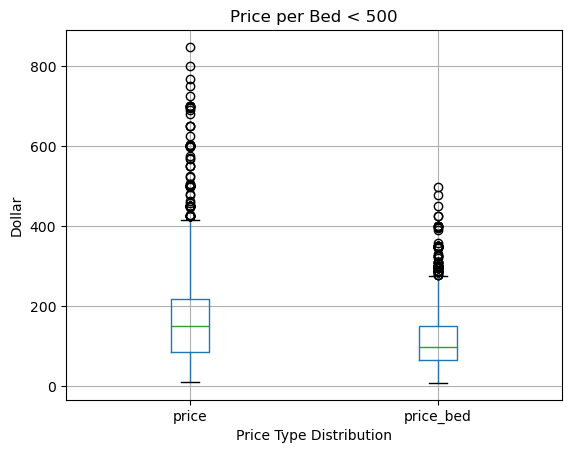

In [633]:
priceplot(bo4,'Price per Bed < 500')

In [634]:
Xp4 = bo4[['beds', 'bathrooms', 'bedrooms','zipcode']]
yp4 = bo4['price']
Xp4_train, Xp4_test, yp4_train, yp4_test = train_test_split(Xp4, yp4, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xp4_train, yp4_train)

LinearRegression()

In [635]:
yp4_test_preds = lm_model.predict(Xp4_test)
rsquared_scorep4 = r2_score(yp4_test, yp4_test_preds)
length_yp4_test = len(yp4_test)
"The r-squared score for your St.4 Total Price Zipcode Model was {} on {} values.".format(rsquared_scorep4, length_yp4_test)

'The r-squared score for your St.4 Total Price Zipcode Model was 0.30422145387734967 on 1029 values.'

In [636]:
Xb4 = bo4[['beds', 'bathrooms', 'bedrooms','zipcode']]
yb4 = bo4['price_bed']
Xb4_train, Xb4_test, yb4_train, yb4_test = train_test_split(Xb4, yb4, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xb4_train, yb4_train)

LinearRegression()

In [637]:
yb4_test_preds = lm_model.predict(Xb4_test)
rsquared_scoreb4 = r2_score(yb4_test, yb4_test_preds)
length_yb4_test = len(yb4_test)
"The r-squared score for your St.4 Bedprice Zipcode Model was {} on {} values.".format(rsquared_scoreb4, length_yb4_test)

'The r-squared score for your St.4 Bedprice Zipcode Model was 0.05898391126471392 on 1029 values.'

## Comparison of the several Models Group 1

Nr: rsquared Total price / rsquared Price Bed (Remarks)

M1: 0,3516 / 0,04812

M2: 0,3401 / 0,06309 (Deleting cheap 9 Beds: good for total Price, bad for Price per Bed)
    
M3: 0,2703 / 0,06121 (Deleting Bed per Bedroom >0,99, increasing Data quality, goog for both), Used as new Basis for the 2-Step Model

M4: 0,3042 / 0,05898 (Deleting expensive Beds, bad for total Price, goog for Price per Bed)
    
    
    

## The first Model Group ist finished.

The first Model group just using Bed / bedroom / bathroom zipcode information ist finished. 
In the next stept room- and property types are use for a mor exact price prediction. 

# 4) Model group 2 using room_type and property_type as well.

In [638]:
# Dummy empty room and property types
bo_dummy = pd.get_dummies(bo, columns =['room_type', 'property_type'])

## 4a) Group 2, Step 1a Total price and Room_Type only

In [639]:
Xzd1 = bo_dummy[['beds', 'bathrooms', 'bedrooms', 'zipcode','room_type_Entire home/apt', 'room_type_Private room', 
                'room_type_Shared room']]
yzd1 = bo_dummy['price']
Xzd1_train, Xzd1_test, yzd1_train, yzd1_test = train_test_split(Xzd1, yzd1, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xzd1_train, yzd1_train)

LinearRegression()

In [640]:
yzd1_test_preds = lm_model.predict(Xzd1_test)
rsquared_scorezd1 = r2_score(yzd1_test, yzd1_test_preds)
length_yzd1_test = len(yzd1_test)
"The r-squared score for your Room Total Price Zipcode Model was {} on {} values.".format(rsquared_scorezd1, length_yzd1_test)

'The r-squared score for your Room Total Price Zipcode Model was 0.536731590664481 on 1041 values.'

## 4b)  Group 2, Step 2a Total price and Appartment_Type only

In [641]:
Xzd2 = bo_dummy[['beds', 'bathrooms', 'bedrooms',
                   'property_type_Apartment','property_type_Bed & Breakfast','property_type_Condominium',
                   'property_type_House', 'property_type_Loft']]
yzd2 = bo_dummy['price']
Xzd2_train, Xzd2_test, yzd2_train, yzd2_test = train_test_split(Xzd2, yzd2, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xzd2_train, yzd2_train)

LinearRegression()

In [642]:
yzd2_test_preds = lm_model.predict(Xzd2_test)
rsquared_scorezd2 = r2_score(yzd2_test, yzd2_test_preds)
length_yzd2_test = len(yzd2_test)
"The r-squared score for your Prop Total Price Zipcode Model was {} on {} values.".format(rsquared_scorezd2, length_yzd2_test)

'The r-squared score for your Prop Total Price Zipcode Model was 0.38727187296441223 on 1041 values.'

## 4c) Group 2, Step 3a Total price and Room with Appartment_Type

In [643]:
Xzd3 = bo_dummy[['beds', 'bathrooms', 'bedrooms', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room',
                  'property_type_Apartment','property_type_Bed & Breakfast','property_type_Condominium',
                   'property_type_House', 'property_type_Loft']]
yzd3 = bo_dummy['price']
Xzd3_train, Xzd3_test, yzd3_train, yzd3_test = train_test_split(Xzd3, yzd3, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xzd3_train, yzd3_train)

LinearRegression()

In [644]:
yzd3_test_preds = lm_model.predict(Xzd3_test)
rsquared_scorezd3 = r2_score(yzd3_test, yzd3_test_preds)
length_yzd3_test = len(yzd3_test)
"The r-squared score for Room-Prop Total Price Zipcode Model was {} on {} values.".format(rsquared_scorezd3, length_yzd3_test)

'The r-squared score for Room-Prop Total Price Zipcode Model was 0.5348992229248272 on 1041 values.'

### Move back from Total Price to Price per Beds

## 4d) Group 2, Step 1b Price per Bed and Room_Type only

In [645]:
Xzb1 = bo_dummy[['beds', 'bathrooms', 'bedrooms', 'room_type_Entire home/apt', 'room_type_Private room', 
                'room_type_Shared room']]
yzb1 = bo_dummy['price_bed']
Xzb1_train, Xzb1_test, yzb1_train, yzb1_test = train_test_split(Xzb1, yzb1, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xzb1_train, yzb1_train)

LinearRegression()

In [646]:
yzb1_test_preds = lm_model.predict(Xzb1_test)
rsquared_scorezb1 = r2_score(yzb1_test, yzb1_test_preds)
length_yzb1_test = len(yzb1_test)
"The r-squared score for Room Bedprice Zipcode Model was {} on {} values.".format(rsquared_scorezb1, length_yzb1_test)

'The r-squared score for Room Bedprice Zipcode Model was 0.32577679228510614 on 1041 values.'

## 4e) Group 2: Step 2b Price per Bed and Appartment_Type only

In [647]:
Xzb2 = bo_dummy[['beds', 'bathrooms', 'bedrooms',
                  'property_type_Apartment','property_type_Bed & Breakfast','property_type_Condominium',
                   'property_type_House', 'property_type_Loft']]
yzb2 = bo_dummy['price_bed']
Xzb2_train, Xzb2_test, yzb2_train, yzb2_test = train_test_split(Xzb2, yzb2, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xzb2_train, yzb2_train)

LinearRegression()

In [648]:
yzb2_test_preds = lm_model.predict(Xzb2_test)
rsquared_scorezb2 = r2_score(yzb2_test, yzb2_test_preds)
length_yzb2_test = len(yzb2_test)
"The r-squared score for Prop Bedprice Zipcode Model was {} on {} values.".format(rsquared_scorezb2, length_yzb2_test)

'The r-squared score for Prop Bedprice Zipcode Model was 0.09436083363931413 on 1041 values.'

## 4f)  Group 2, Step 3a Price per Bed and Room with Appartment_Type

In [649]:
Xzb3 = bo_dummy[['beds', 'bathrooms', 'bedrooms', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room',
                  'property_type_Apartment','property_type_Bed & Breakfast','property_type_Condominium',
                   'property_type_House', 'property_type_Loft']]
yzb3 = bo_dummy['price_bed']
Xzb3_train, Xzb3_test, yzb3_train, yzb3_test = train_test_split(Xzb3, yzb3, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xzb3_train, yzb3_train)

LinearRegression()

In [650]:
yzb3_test_preds = lm_model.predict(Xzb3_test)
rsquared_scorezb3 = r2_score(yzb3_test, yzb3_test_preds)
length_yzb3_test = len(yzb3_test)
"The r-squared score for Room-Prop Bedprice Zipcode Model was {} on {} values.".format(rsquared_scorezb3, length_yzb3_test)

'The r-squared score for Room-Prop Bedprice Zipcode Model was 0.32207342697155505 on 1041 values.'

In [651]:
# "The r-squared score for your Room_Type Price Zipcode Model was {} on {} values.".format(rsquared_scorezd1, length_yzd1_test),
# "The r-squared score for your Property Price Zipcode Model was {} on {} values.".format(rsquared_scorezd2, length_yzd2_test),
# "The r-squared score for your Room and Property Zipcode Model was {} on {} values.".format(rsquared_scorezd3, length_yzd3_test),
# "The r-squared score for your Room_Type Bed-Zipcode Model was {} on {} values.".format(rsquared_scorezb1, length_yzb1_test),
# "The r-squared score for your Property Bed-Zipcode Model was {} on {} values.".format(rsquared_scorezb2, length_yzb2_test),
# "The r-squared score for your Property Bed-Zipcode Model was {} on {} values.".format(rsquared_scorezb3, length_yzb3_test)


In [652]:
"Room Total Price: {}, Prop Total Price: {}, Room-Prop Total Price: {},                  Room     Bedprice: {},  Prop Bedprice: {}, Room Prop Bedprice: {}".format(rsquared_scorezd1,rsquared_scorezd2,rsquared_scorezd3, rsquared_scorezb1, rsquared_scorezb2, rsquared_scorezb3,) 

'Room Total Price: 0.536731590664481, Prop Total Price: 0.38727187296441223, Room-Prop Total Price: 0.5348992229248272,                  Room     Bedprice: 0.32577679228510614,  Prop Bedprice: 0.09436083363931413, Room Prop Bedprice: 0.32207342697155505'

### Comparison of the several Models Group 2
Type: rsquared Total Price / rsquared Price Bed (Remarks)

Room Type: 0,5367 / 0,32578 

Prop_ Type: 0,3873 / 0,09436

Room-Prop: 0,5349 / 0,32207

### Conclusion: 
The Property Type is more comparable, since the rquared values within the property types are lower 
    than in the other models. It is clear to see, that the group "Boat" does not fit into room-typ Private room (to expensive, see heatmaps below).
    We could deleate the boats to improve the quality of the model, but this ist not shown in here.

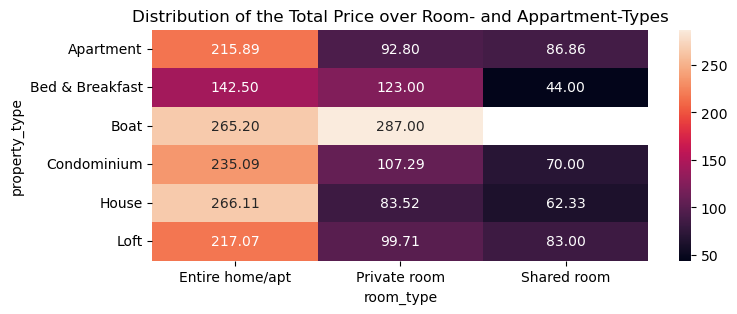

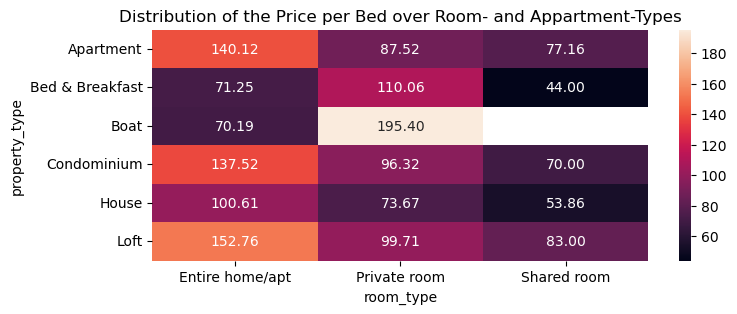

In [653]:
pricemaps(bo3)

### Second Model group ist finished. 
This Approach is better for a price prediction, however the spreading between small,
expensive with just a low number of beds and large accomodation with a high number of beds seems to bw too high. 
Even knowing, that these different types are usually located differently. Therefore a third, final approach is used.

# 5) Final Approach ist a two Step Model for small and large Accomodations:
smaller than 4 Beds and larger than 3/2 beds (2 beds are used also to increase the 
number of large datasets).

bo_small, bo_large and bo_large_plus are the relevant databases.

In [654]:
# Defind small, large and large_plus databases
bo_small = bo3[bo3['beds'] < 4]
bo_large = bo3[bo3['beds'] > 3]
bo_large_plus = bo3[bo3['beds'] > 2]

Checking size of the several databases

In [655]:
bo3.shape[0]

3436

In [656]:
bo_small.shape[0]

3265

In [657]:
bo_large.shape[0]

171

In [658]:
bo_large_plus.shape[0]

438

## 5a) Showing several known Distributions or Heatmaps
Type, Size and Total Price / Perice per Bed Distribution of the new Small, Large and Large Plus Database to understand the differences.

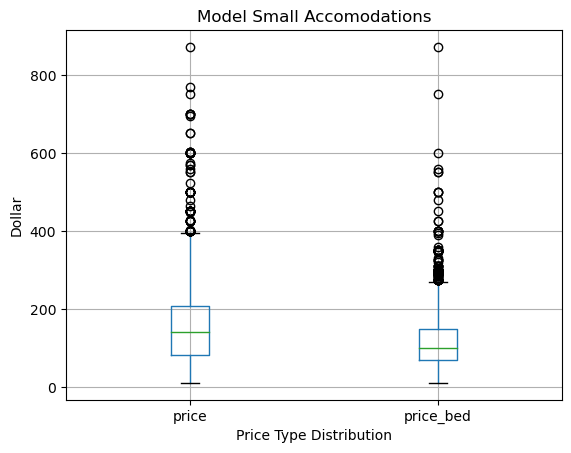

In [659]:
priceplot(bo_small,'Model Small Accomodations')

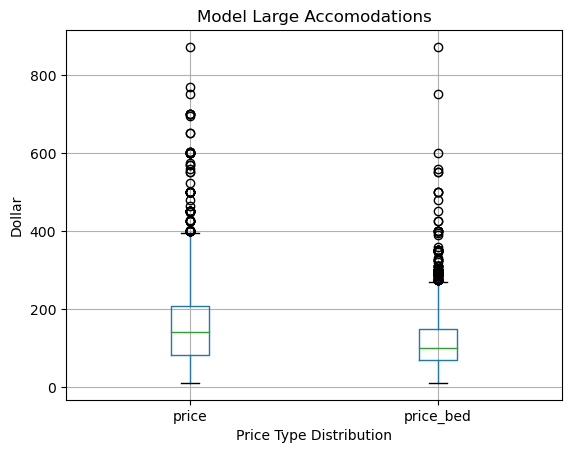

In [660]:
priceplot(bo_small,'Model Large Accomodations')

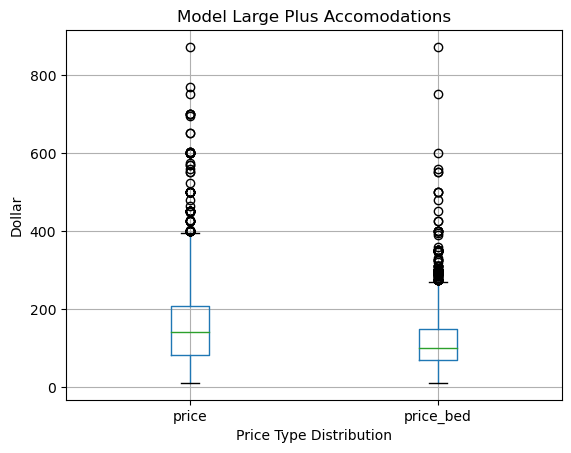

In [661]:
priceplot(bo_small,'Model Large Plus Accomodations')

### The Large Plus Databases incluses some more expensive as well as cheap beds

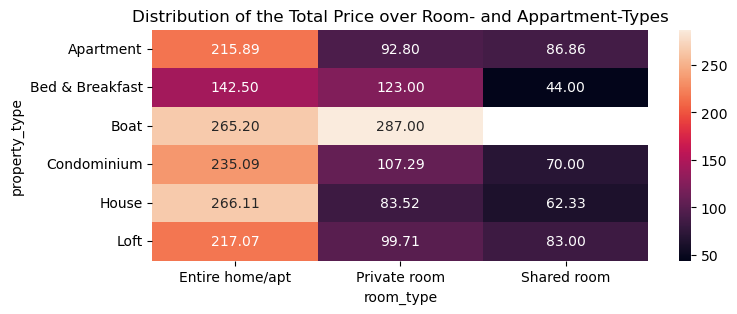

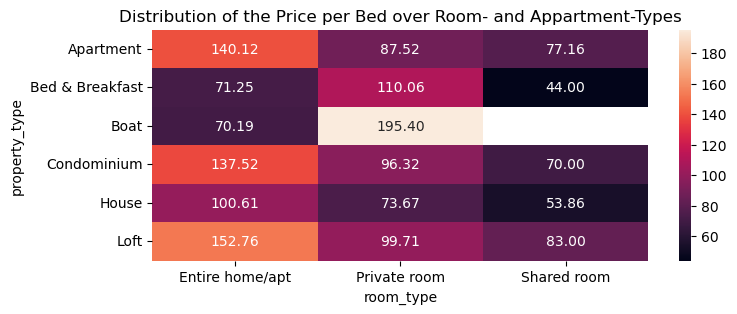

In [662]:
pricemaps(bo_small)

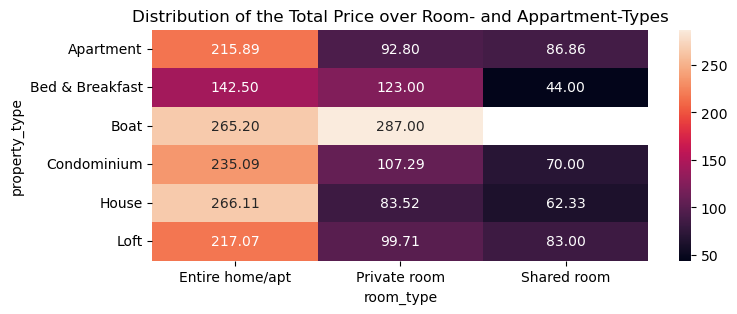

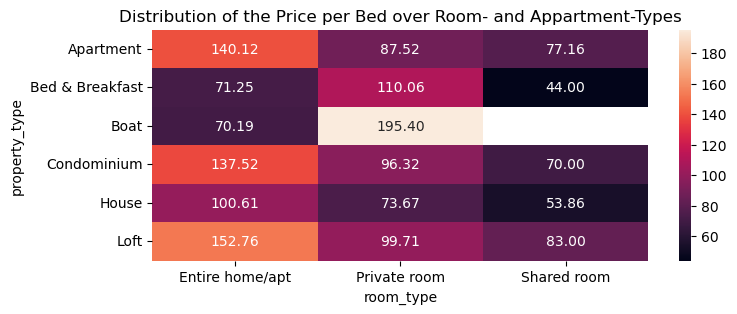

In [663]:
pricemaps(bo_large)

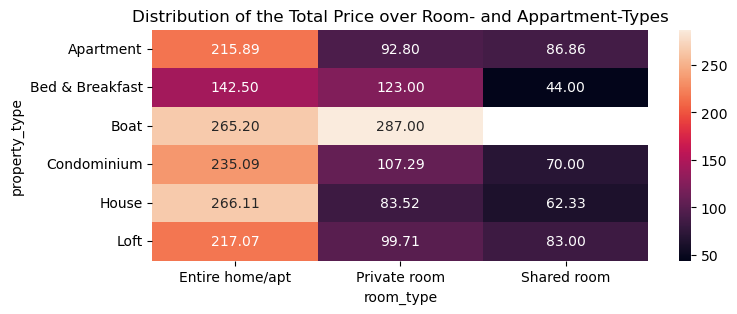

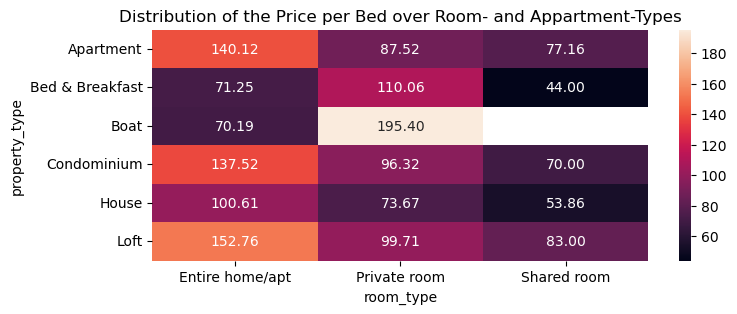

In [664]:
pricemaps(bo_large_plus)

### Boat Problem can be seen clearly!
Average Total Price and Price per Bed does not fitting to private room

###


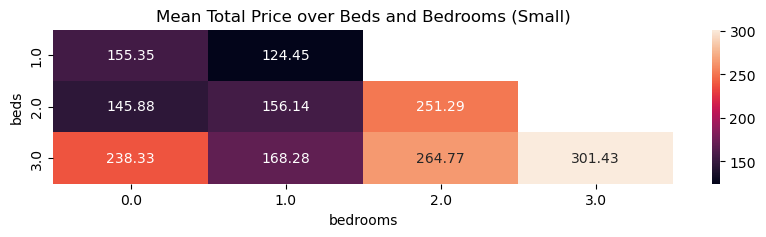

In [665]:
plt.figure(figsize=(10,2));
plt.title('Mean Total Price over Beds and Bedrooms (Small)')
sns.heatmap(bo_small.groupby(['beds', 'bedrooms']).price.mean().unstack(),annot=True, fmt=".2f");

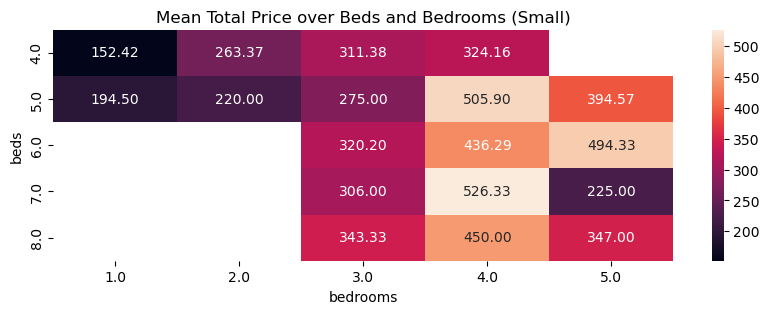

In [666]:
plt.figure(figsize=(10,3));
plt.title('Mean Total Price over Beds and Bedrooms (Small)')
sns.heatmap(bo_large.groupby(['beds', 'bedrooms']).price.mean().unstack(),annot=True, fmt=".2f");

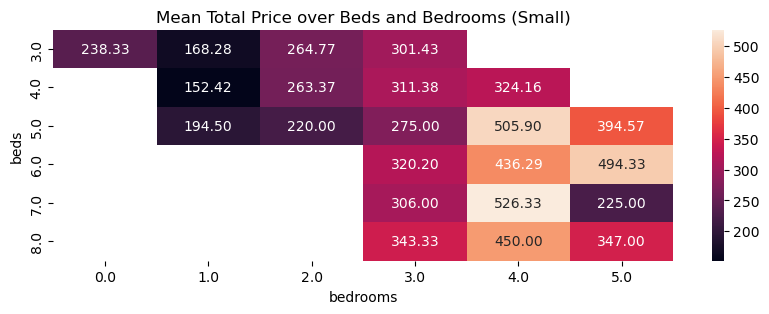

In [667]:
plt.figure(figsize=(10,3));
plt.title('Mean Total Price over Beds and Bedrooms (Small)')
sns.heatmap(bo_large_plus.groupby(['beds', 'bedrooms']).price.mean().unstack(),annot=True, fmt=".2f");

## 5b) Modelling Small part

In [668]:
Xps3 = bo_small[['beds', 'bathrooms', 'bedrooms','zipcode']]
yps3 = bo_small['price']
Xps3_train, Xps3_test, yps3_train, yps3_test = train_test_split(Xps3, yps3, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xps3_train, yps3_train)

LinearRegression()

In [669]:
yps3_test_preds = lm_model.predict(Xps3_test)
rsquared_scoreps3 = r2_score(yps3_test, yps3_test_preds)
length_yps3_test = len(yps3_test)
"The r-squared score for your Small Total Price Zipcode Model was {} on {} values.".format(rsquared_scoreps3, length_yps3_test)

'The r-squared score for your Small Total Price Zipcode Model was 0.2141117906204224 on 980 values.'

In [670]:
Xbs3 = bo_small[['beds', 'bathrooms', 'bedrooms','zipcode']]
ybs3 = bo_small['price_bed']
Xbs3_train, Xbs3_test, ybs3_train, ybs3_test = train_test_split(Xbs3, ybs3, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xbs3_train, ybs3_train)

LinearRegression()

In [671]:
ybs3_test_preds = lm_model.predict(Xbs3_test)
rsquared_scorebs3 = r2_score(ybs3_test, ybs3_test_preds)
length_ybs3_test = len(ybs3_test)
"The r-squared score for your Small Bedprice Zipcode Model was {} on {} values.".format(rsquared_scorebs3, length_ybs3_test)

'The r-squared score for your Small Bedprice Zipcode Model was 0.04300164527981354 on 980 values.'

## 5c) Modelling Large Part

In [672]:
Xpl3 = bo_large[['beds', 'bathrooms', 'bedrooms','zipcode']]
ypl3 = bo_large['price']
Xpl3_train, Xpl3_test, ypl3_train, ypl3_test = train_test_split(Xpl3, ypl3, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xpl3_train, ypl3_train)

LinearRegression()

In [673]:
ypl3_test_preds = lm_model.predict(Xpl3_test)
rsquared_scorepl3 = r2_score(ypl3_test, ypl3_test_preds)
length_ypl3_test = len(ypl3_test)
"The r-squared score for your Large Total Price Zipcode Model was {} on {} values.".format(rsquared_scorepl3, length_ypl3_test)

'The r-squared score for your Large Total Price Zipcode Model was 0.21376952001634442 on 52 values.'

In [674]:
Xbl3 = bo_large[['beds', 'bathrooms', 'bedrooms','zipcode']]
ybl3 = bo_large['price_bed']
Xbl3_train, Xbl3_test, ybl3_train, ybl3_test = train_test_split(Xbl3, ybl3, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xbl3_train, ybl3_train)

LinearRegression()

In [675]:
ybl3_test_preds = lm_model.predict(Xbl3_test)
rsquared_scorebl3 = r2_score(ybl3_test, ybl3_test_preds)
length_ybl3_test = len(ybl3_test)
"The r-squared score for your Large Bedprice Zipcode Model was {} on {} values.".format(rsquared_scorebl3, length_ybl3_test)

'The r-squared score for your Large Bedprice Zipcode Model was 0.06133063258148175 on 52 values.'

## 5d) Modelling Large Plus Part

In [676]:
Xplp3 = bo_large_plus[['beds', 'bathrooms', 'bedrooms','zipcode']]
yplp3 = bo_large_plus['price']
Xplp3_train, Xplp3_test, yplp3_train, yplp3_test = train_test_split(Xplp3, yplp3, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xplp3_train, yplp3_train)

LinearRegression()

In [677]:
yplp3_test_preds = lm_model.predict(Xplp3_test)
rsquared_scoreplp3 = r2_score(yplp3_test, yplp3_test_preds)
length_yplp3_test = len(yplp3_test)
"The r-squared score Large Plus Total Price Zipcode Model was {} on {} values.".format(rsquared_scoreplp3, length_yplp3_test)

'The r-squared score Large Plus Total Price Zipcode Model was 0.13994825877853634 on 132 values.'

In [678]:
Xblp3 = bo_large_plus[['beds', 'bathrooms', 'bedrooms','zipcode']]
yblp3 = bo_large_plus['price_bed']
Xblp3_train, Xblp3_test, yblp3_train, yblp3_test = train_test_split(Xblp3, yblp3, test_size=.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(Xblp3_train, yblp3_train)

LinearRegression()

In [679]:
yblp3_test_preds = lm_model.predict(Xblp3_test)
rsquared_scoreblp3 = r2_score(yblp3_test, yblp3_test_preds)
length_yblp3_test = len(yblp3_test)
"The r-squared score Large Plus Bedprice Zipcode Model was {} on {} values.".format(rsquared_scoreblp3, length_yblp3_test)

'The r-squared score Large Plus Bedprice Zipcode Model was 0.17744683923582305 on 132 values.'

### Comparison of the several Models 

Nr: rsquared Total price / rsquared Price Bed (Remarks)

Basis M3 1Step: 0,2703 / 0,06121 

Small Two Step: 0.2141 / 0.04300 on 980 values
    
Large Two Step: 0.2137 / 0.06133 on 052 values.
    
Large Plus 2.St: 0.1399 / 0.17744 on 132 values.

# Conclusion: 

The Small and Large Two Step Model is improving the quality of the Boston Zipcode Model further based on better business understanding.
    
The Differences between Large and Large Plus are very interessing:
As pointed out earler we have to figure out what ist more importend price or price per bed, since the number of 
"large accomodation datasets" ist still low, hence, a more detailed consideration for outliers and data quality 
has to be done in a next step.

In [680]:
"Final Check: It is running  very fine"

'Final Check: It is running  very fine'